<img src="AUEB.png" /> <img src="MSc_BA.png" />

# Athens University of Economics and Business
# School of Business
# Department of Management Science & Technology
# Master of Science in Business Analytics
___

<table style='float:left;font-size: 20px;'>
    <tr>
        <th style='text-align: left;'>Program:</th>
        <td style='text-align: left;'>Full-Time</td>
    </tr>
    <tr>
        <th style='text-align: left;'>Quarter:</th>
        <td style='text-align: left;'>2nd (Winter Quarter)</td>
    </tr>
    <tr>
        <th style='text-align: left;'>Course:</th>
        <td style='text-align: left;'>Analytics Practicum I</td>
    </tr>
    <tr>
        <th style='text-align: left;'>Assignment No:</th>
        <td style='text-align: left;'>2</td>
    </tr> 
    <tr>
        <th style='text-align: left;'>Student (Registration No):</th>
        <td style='text-align: left;'>Souflas Eleftherios-Efthymios (f2822217)</td>
    </tr>
</table>

___
# Modern Slavery Assignment

Even though slavery is illegal, forty million people are estimated to live under some form of modern slavery across the globe. These forms of modern slavery include a wide variety of practices such as forced labour, debt bondage, forced marriage, sexual exploitation, bonded labour, and human trafficking.

Researchers have been trying to estimate the prevalence of modern slavery, as well as factors that can help with this prediction. Machine Learning techniques can help in this endeavour, as has been shown in the following publication:

Lavelle-Hill, R., Smith, G., Mazumder, A. et al. Machine learning methods for "wicked" problems: exploring the complex drivers of modern slavery. Humanities and Social Sciences Communications 8, 274 (2021). https://doi.org/10.1057/s41599-021-00938-znment, Python and some of its libraries were used.

In this assignment, I tried to familiarize with the methodology followed by the authors, using Python and its libraries (mainly scikit-learn as it is a great library for machine learning purposes).

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Q1: Data Preprocessing

Information on the open source variables indicated that often data had been collected over multiple years. When this was the case, the most recent year in the collection time frame was recorded. The year the data was collected was an important part of the data processing as for 22 countries there were two dependent variable data points—slavery prevalence in 2016 and slavery prevalence in 2018. Therefore, data was sought to cover both these time periods.

In [2]:
training = pd.read_csv('Data/training.csv')
print(training.Data_year.unique())
print('Number of countries having data for 2016 and 2018 were :',len(training) - training.Country.nunique())
print('Number of variables that had >50% of data missing were :', 
      (training[training.columns].isna().sum() > len(training)/2).sum())

[2018 2016]
Number of countries having data for 2016 and 2018 were : 22
Number of variables that had >50% of data missing were : 0


Because there was a column named `Work_rightCIRI` and another one named `Work_rightCIRI_2011` and had some slight differences in their values, and because the values were extracted from the Silverman and Landman (2019)	according to the [variable descriptions](https://github.com/ml-slavery/ml-slavery/blob/main/Data/Meta_Data/Variable_descriptions.csv), it is assumed that `Work_rightCIRI` is a value extracted at a time close to 2019. I followed the assumption presented in [X_missing_vars.csv](https://github.com/ml-slavery/ml-slavery/blob/main/Data/Meta_Data/X_missing_vars.csv) and made them one variable taking their average value as the value of the newly created one variable (we can see in the `X_missing_vars.csv` that there are values of 0.5 and 1.5 that are the results of the average of 0 and 1 for the former case (0.5) and of 1 and 2 for the latter case (1.5)) when the data were depicting a country in 2016 and sustained the value of `Work_rightCIRI` for all 2018 rows.

In [3]:
print('Tunisia Data for Work_rightCIRI before merging the two columns')
print(training.loc[training.Country == 'Tunisia',['Work_rightCIRI','Work_rightCIRI_2011']])
training.rename(columns={"Work_rightCIRI": "Work_rightCIRI2"}, inplace=True,)
training['Work_rightCIRI'] = -0.5
training.loc[training.Data_year == 2018, 'Work_rightCIRI'] = training.loc[training.Data_year == 2018, 'Work_rightCIRI2']
training.loc[training.Data_year == 2016, 'Work_rightCIRI'] = \
    (training.loc[training.Data_year == 2016, 'Work_rightCIRI2'] + \
     training.loc[training.Data_year == 2016, 'Work_rightCIRI_2011']) / 2
training = training.drop(['Work_rightCIRI_2011','Work_rightCIRI2'], axis=1)
print('Tunisia Data for Work_rightCIRI after merging the two columns')
training.loc[training.Country == 'Tunisia', 'Work_rightCIRI']

Tunisia Data for Work_rightCIRI before merging the two columns
    Work_rightCIRI  Work_rightCIRI_2011
64               1                    2
65               1                    2
Tunisia Data for Work_rightCIRI after merging the two columns


64    1.5
65    1.0
Name: Work_rightCIRI, dtype: float64

Overall, there was not enough data specific to the years 2016 and 2018 so the data was grouped by time period (2016 and before, and post 2016) and the most recent data from each group selected. As an example, the Physical Security of Women Scale had data only from the years 2014 and 2019, therefore the former went in group 1 to predict slavery in 2016 and the latter went into group 2 to predict slavery in 2018. 

There were also columns containing data for a single year only and following the assumptions implied in the [Supplementary Material - page 7](https://static-content.springer.com/esm/art%3A10.1057%2Fs41599-021-00938-z/MediaObjects/41599_2021_938_MOESM1_ESM.pdf), the data from the year where it was refering to was pasted with the forementioned value, whereas for the other group's data a missing value was implied. For example, the Taboo and security for wonen reporting rape	measure (`Rape_report`) had data only for 2015, so the data from this columns was pasted for the countries that had data for 2016 and for the countries that had data for 2018 a missing value was implied.

Grouping the data in this manner reduced the missing data, but with the caveat that the features were assumed to be relatively stable between 2011 and 2016 for group 1, and between 2016 to 2019 for group 2.

In [4]:
year_columns = sorted(training.filter(regex='_[0-9]{4}').columns.tolist())
print('Columns containing year:', year_columns)
training['AIDS_Orph'] = math.nan
training.loc[training.Data_year == 2016, 'AIDS_Orph'] = training.loc[training.Data_year == 2016, 'AIDS_Orph_2016']
training.loc[training.Data_year == 2018, 'AIDS_Orph'] = training.loc[training.Data_year == 2018, 'AIDS_Orph_2018']
training['AIDS_death'] = math.nan
training.loc[training.Data_year == 2016, 'AIDS_death'] = training.loc[training.Data_year == 2016, 'AIDS_death_2016']
training.loc[training.Data_year == 2018, 'AIDS_death'] = training.loc[training.Data_year == 2018, 'AIDS_death_2018']
training['Phys_secF'] = math.nan
training.loc[training.Data_year == 2016, 'Phys_secF'] = training.loc[training.Data_year == 2016, 'Phys_secF_2014']
training.loc[training.Data_year == 2018, 'Phys_secF'] = training.loc[training.Data_year == 2018, 'Phys_secF_2019']
training['Econ_right_F'] = math.nan
training.loc[training.Data_year == 2016, 'Econ_right_F'] = training.loc[training.Data_year == 2016, 'Econ_right_F_2011']
training['Extrajud_kill'] = math.nan
training.loc[training.Data_year == 2016, 'Extrajud_kill'] = training.loc[training.Data_year == 2016, 'Extrajud_kill_2011']
training['Free_assem'] = math.nan
training.loc[training.Data_year == 2016, 'Free_assem'] = training.loc[training.Data_year == 2016, 'Free_assem_2011']
training['Free_polit'] = math.nan
training.loc[training.Data_year == 2016, 'Free_polit'] = training.loc[training.Data_year == 2016, 'Free_polit_2011']
training['Free_speech'] = math.nan
training.loc[training.Data_year == 2016, 'Free_speech'] = training.loc[training.Data_year == 2016, 'Free_speech_2011']
training['Freemv_dom'] = math.nan
training.loc[training.Data_year == 2016, 'Freemv_dom'] = training.loc[training.Data_year == 2016, 'Freemv_dom_2011']
training['Freemv_foreign'] = math.nan
training.loc[training.Data_year == 2016, 'Freemv_foreign'] = training.loc[training.Data_year == 2016, 'Freemv_foreign_2011']
training['GDPpc'] = math.nan
training.loc[training.Data_year == 2016, 'GDPpc'] = training.loc[training.Data_year == 2016, 'GDPpc_2016']
training['Gender_equal'] = math.nan
training.loc[training.Data_year == 2016, 'Gender_equal'] = training.loc[training.Data_year == 2016, 'Gender_equal_2015']
training['Hum_traff'] = math.nan
training.loc[training.Data_year == 2018, 'Hum_traff'] = training.loc[training.Data_year == 2018, 'Hum_traff_2019']
training['Indep_judic'] = math.nan
training.loc[training.Data_year == 2016, 'Indep_judic'] = training.loc[training.Data_year == 2016, 'Indep_judic_2011']
training['Physrights_indx'] = math.nan
training.loc[training.Data_year == 2016, 'Physrights_indx'] = training.loc[training.Data_year == 2016, 'Physrights_indx_2011']
training['Pol_impris'] = math.nan
training.loc[training.Data_year == 2016, 'Pol_impris'] = training.loc[training.Data_year == 2016, 'Pol_impris_2011']
training['Pol_right_F'] = math.nan
training.loc[training.Data_year == 2016, 'Pol_right_F'] = training.loc[training.Data_year == 2016, 'Pol_right_F_2011']
training['Polrights_indx'] = math.nan
training.loc[training.Data_year == 2016, 'Polrights_indx'] = training.loc[training.Data_year == 2016, 'Polrights_indx_2011']
training['Rape_compl'] = math.nan
training.loc[training.Data_year == 2018, 'Rape_compl'] = training.loc[training.Data_year == 2018, 'Rape_compl_2018']
training['Rape_enclave'] = math.nan
training.loc[training.Data_year == 2016, 'Rape_enclave'] = training.loc[training.Data_year == 2016, 'Rape_enclave_2015']
training['Rape_prev'] = math.nan
training.loc[training.Data_year == 2018, 'Rape_prev'] = training.loc[training.Data_year == 2018, 'Rape_prev_2018']
training['Rape_report'] = math.nan
training.loc[training.Data_year == 2016, 'Rape_report'] = training.loc[training.Data_year == 2016, 'Rape_report_2015']
training['Relig_freeCIRI'] = math.nan
training.loc[training.Data_year == 2016, 'Relig_freeCIRI'] = training.loc[training.Data_year == 2016, 'Relig_freeCIRI_2011']
training['Risk_masskill'] = math.nan
training.loc[training.Data_year == 2018, 'Risk_masskill'] = training.loc[training.Data_year == 2018, 'Risk_masskill_2018']
training['SDGI'] = math.nan
training.loc[training.Data_year == 2016, 'SDGI'] = training.loc[training.Data_year == 2016, 'SDGI_2016']
training['Torture'] = math.nan
training.loc[training.Data_year == 2016, 'Torture'] = training.loc[training.Data_year == 2016, 'Torture_2011']
training = training.drop(year_columns, axis=1)

Columns containing year: ['AIDS_Orph_2016', 'AIDS_Orph_2018', 'AIDS_death_2016', 'AIDS_death_2018', 'Econ_right_F_2011', 'Extrajud_kill_2011', 'Free_assem_2011', 'Free_polit_2011', 'Free_speech_2011', 'Freemv_dom_2011', 'Freemv_foreign_2011', 'GDPpc_2016', 'Gender_equal_2015', 'Hum_traff_2019', 'Indep_judic_2011', 'Phys_secF_2014', 'Phys_secF_2019', 'Physrights_indx_2011', 'Pol_impris_2011', 'Pol_right_F_2011', 'Polrights_indx_2011', 'Rape_compl_2018', 'Rape_enclave_2015', 'Rape_prev_2018', 'Rape_report_2015', 'Relig_freeCIRI_2011', 'Risk_masskill_2018', 'SDGI_2016', 'Torture_2011']


Then, I created an index for each row of the dataset with the country and the year the data were selected from, removing at the same time the two columns holding the forementioned information. The same was applied to the test dataset also.

In [5]:
# training
training.index = training["Country"] + '_' + training["Data_year"].astype(str)
training = training.drop(['Country','Data_year'], axis=1)
training.rename(index={'Democratic Republic of the Congo_2018':'Dem_Rep_Congo_2018'}, inplace=True)
print('Training dataset\'s columns:', sorted(training.columns.tolist()))
print()
# test
OOS_Data = pd.read_csv('Data/OOS_Data.csv')
OOS_Data.index = OOS_Data["Country"] + '_' + OOS_Data["Data_year"].astype(str)
OOS_Data = OOS_Data.drop(['Country','Data_year'], axis=1)
print('Test dataset\'s columns:', sorted(OOS_Data.columns.tolist()))

Training dataset's columns: ['AIDS_Orph', 'AIDS_death', 'ATMs', 'Americas', 'Armedcon', 'Asia', 'Battle_deaths', 'Broadband', 'CPI', 'Cereal_yield', 'Child_lab', 'Climate_chg_vuln', 'Co2_energy_pc', 'Co2_fuel', 'Democ', 'Econ_right_F', 'Electric_acc', 'Ethnic_fract', 'Europe', 'Extrajud_kill', 'FDI', 'F_parliam', 'F_school', 'Fish_overexploit', 'Forest_change', 'Free_assem', 'Free_discuss', 'Free_polit', 'Free_speech', 'Freemv_F', 'Freemv_M', 'Freemv_dom', 'Freemv_foreign', 'Freshwater', 'Fuel_acc', 'GDPpc', 'GDPpc_growth', 'Gender_equal', 'Gov_efficien', 'Growth_rate', 'Homicides', 'Hum_traff', 'Indep_judic', 'Inequality', 'Infant_mort', 'Infant_vaccines', 'Infrastruct', 'Internet_use', 'KOF_Globalis', 'Lack_contraception', 'Life_expect', 'Literacy_15_24yrs', 'M_East_N_Africa', 'M_school', 'Masskill_ever', 'Masskill_ongo', 'Maternal_mort', 'Minority_rule', 'Neonatal_mort', 'Ocean_biodiv', 'Ocean_clean', 'Ocean_fisheries', 'Ocean_protect', 'Party_ban', 'Phys_secF', 'Physrights_indx', '

Then, I removed all columns that were not common to both datasets and sorted its columns to be in same position across both datasets.

In [6]:
print(OOS_Data.columns.symmetric_difference(training.columns))
OOS_Data_out = OOS_Data.loc[:,OOS_Data.columns.difference(training.columns)]
OOS_Data = OOS_Data.drop(OOS_Data.columns.difference(training.columns), axis=1)
training_data_out = training.loc[:,training.columns.difference(OOS_Data.columns)]
training = training.drop(training.columns.difference(OOS_Data.columns), axis=1)
print(OOS_Data.columns.symmetric_difference(training.columns))
training = training.sort_index(axis=1)
OOS_Data = OOS_Data.sort_index(axis=1)
print('Do train and test datasets have the same number of columns?\n',len(OOS_Data.columns) == len(training.columns))

Index(['Americas', 'Asia', 'Europe', 'Hum_traff', 'M_East_N_Africa',
       'Pop_dens', 'Region', 'Risk_masskill', 'Rural_population',
       'Russia_Eurasia', 'SDGI', 'Subsah_Africa', 'Urban_population'],
      dtype='object')
Index([], dtype='object')
Do train and test datasets have the same number of columns?
 True


In [7]:
# Region = training.Region
# Asia = training.Asia
# Subsah_Africa = training.Subsah_Africa
# Americas = training.Americas
# Europe = training.Europe
# M_East_N_Africa = training.M_East_N_Africa
# Russia_Eurasia = training.Russia_Eurasia
# training = training.drop(['Region','Asia','Subsah_Africa','Americas','Europe','M_East_N_Africa','Russia_Eurasia'], axis=1)
# training_arch = training.copy()
# integers = ['int16', 'int32', 'int64']
# int_cols = training_arch.select_dtypes(include=integers).columns
# training.iloc[:,2]
# # transform non-numerical labels (as long as they are hashable and comparable) to numerical labels
# le = preprocessing.LabelEncoder()
# training.iloc[:,0] = le.fit_transform(training.iloc[:,0])
# training.iloc[:,2] = le.fit_transform(training.iloc[:,2])

Then, remaining data were imputed in two steps. 
Where a country had either 2016 or 2018 data, the data from the year where it was available was used for both years (therefore, in a small number of cases the same feature value was used to predict two different dependent variable values—prevalence in 2016 and 2018). For example, `Physrights_indx` of Vietnam had value for 2016, but was not having for 2018.

In [8]:
training.loc[['Vietnam_2016','Vietnam_2018'],:].isna()
double_countries_2016 = [5,8,11,17,20,22,26,28,30,36,38,42,44,46,48,50,52,55,59,61,64,68]
n = len(training.columns)
for i in double_countries_2016:
    for j in range(n):
        if math.isnan(training.iloc[i,j]):
            training.iloc[i,j] = training.iloc[i+1,j]
double_countries_2018 = list(map(lambda x:x+1, double_countries_2016))
for i in double_countries_2018:
    for j in range(n):
        if math.isnan(training.iloc[i,j]):
            training.iloc[i,j] = training.iloc[i-1,j]

After this, the subsequent missing values were minimal, and can be viewed in the [Supplementary Material - page 7](https://static-content.springer.com/esm/art%3A10.1057%2Fs41599-021-00938-z/MediaObjects/41599_2021_938_MOESM1_ESM.pdf). For ease of use, it is replicated below with the 103 independent variables of the training dataset that are common for both datasets.

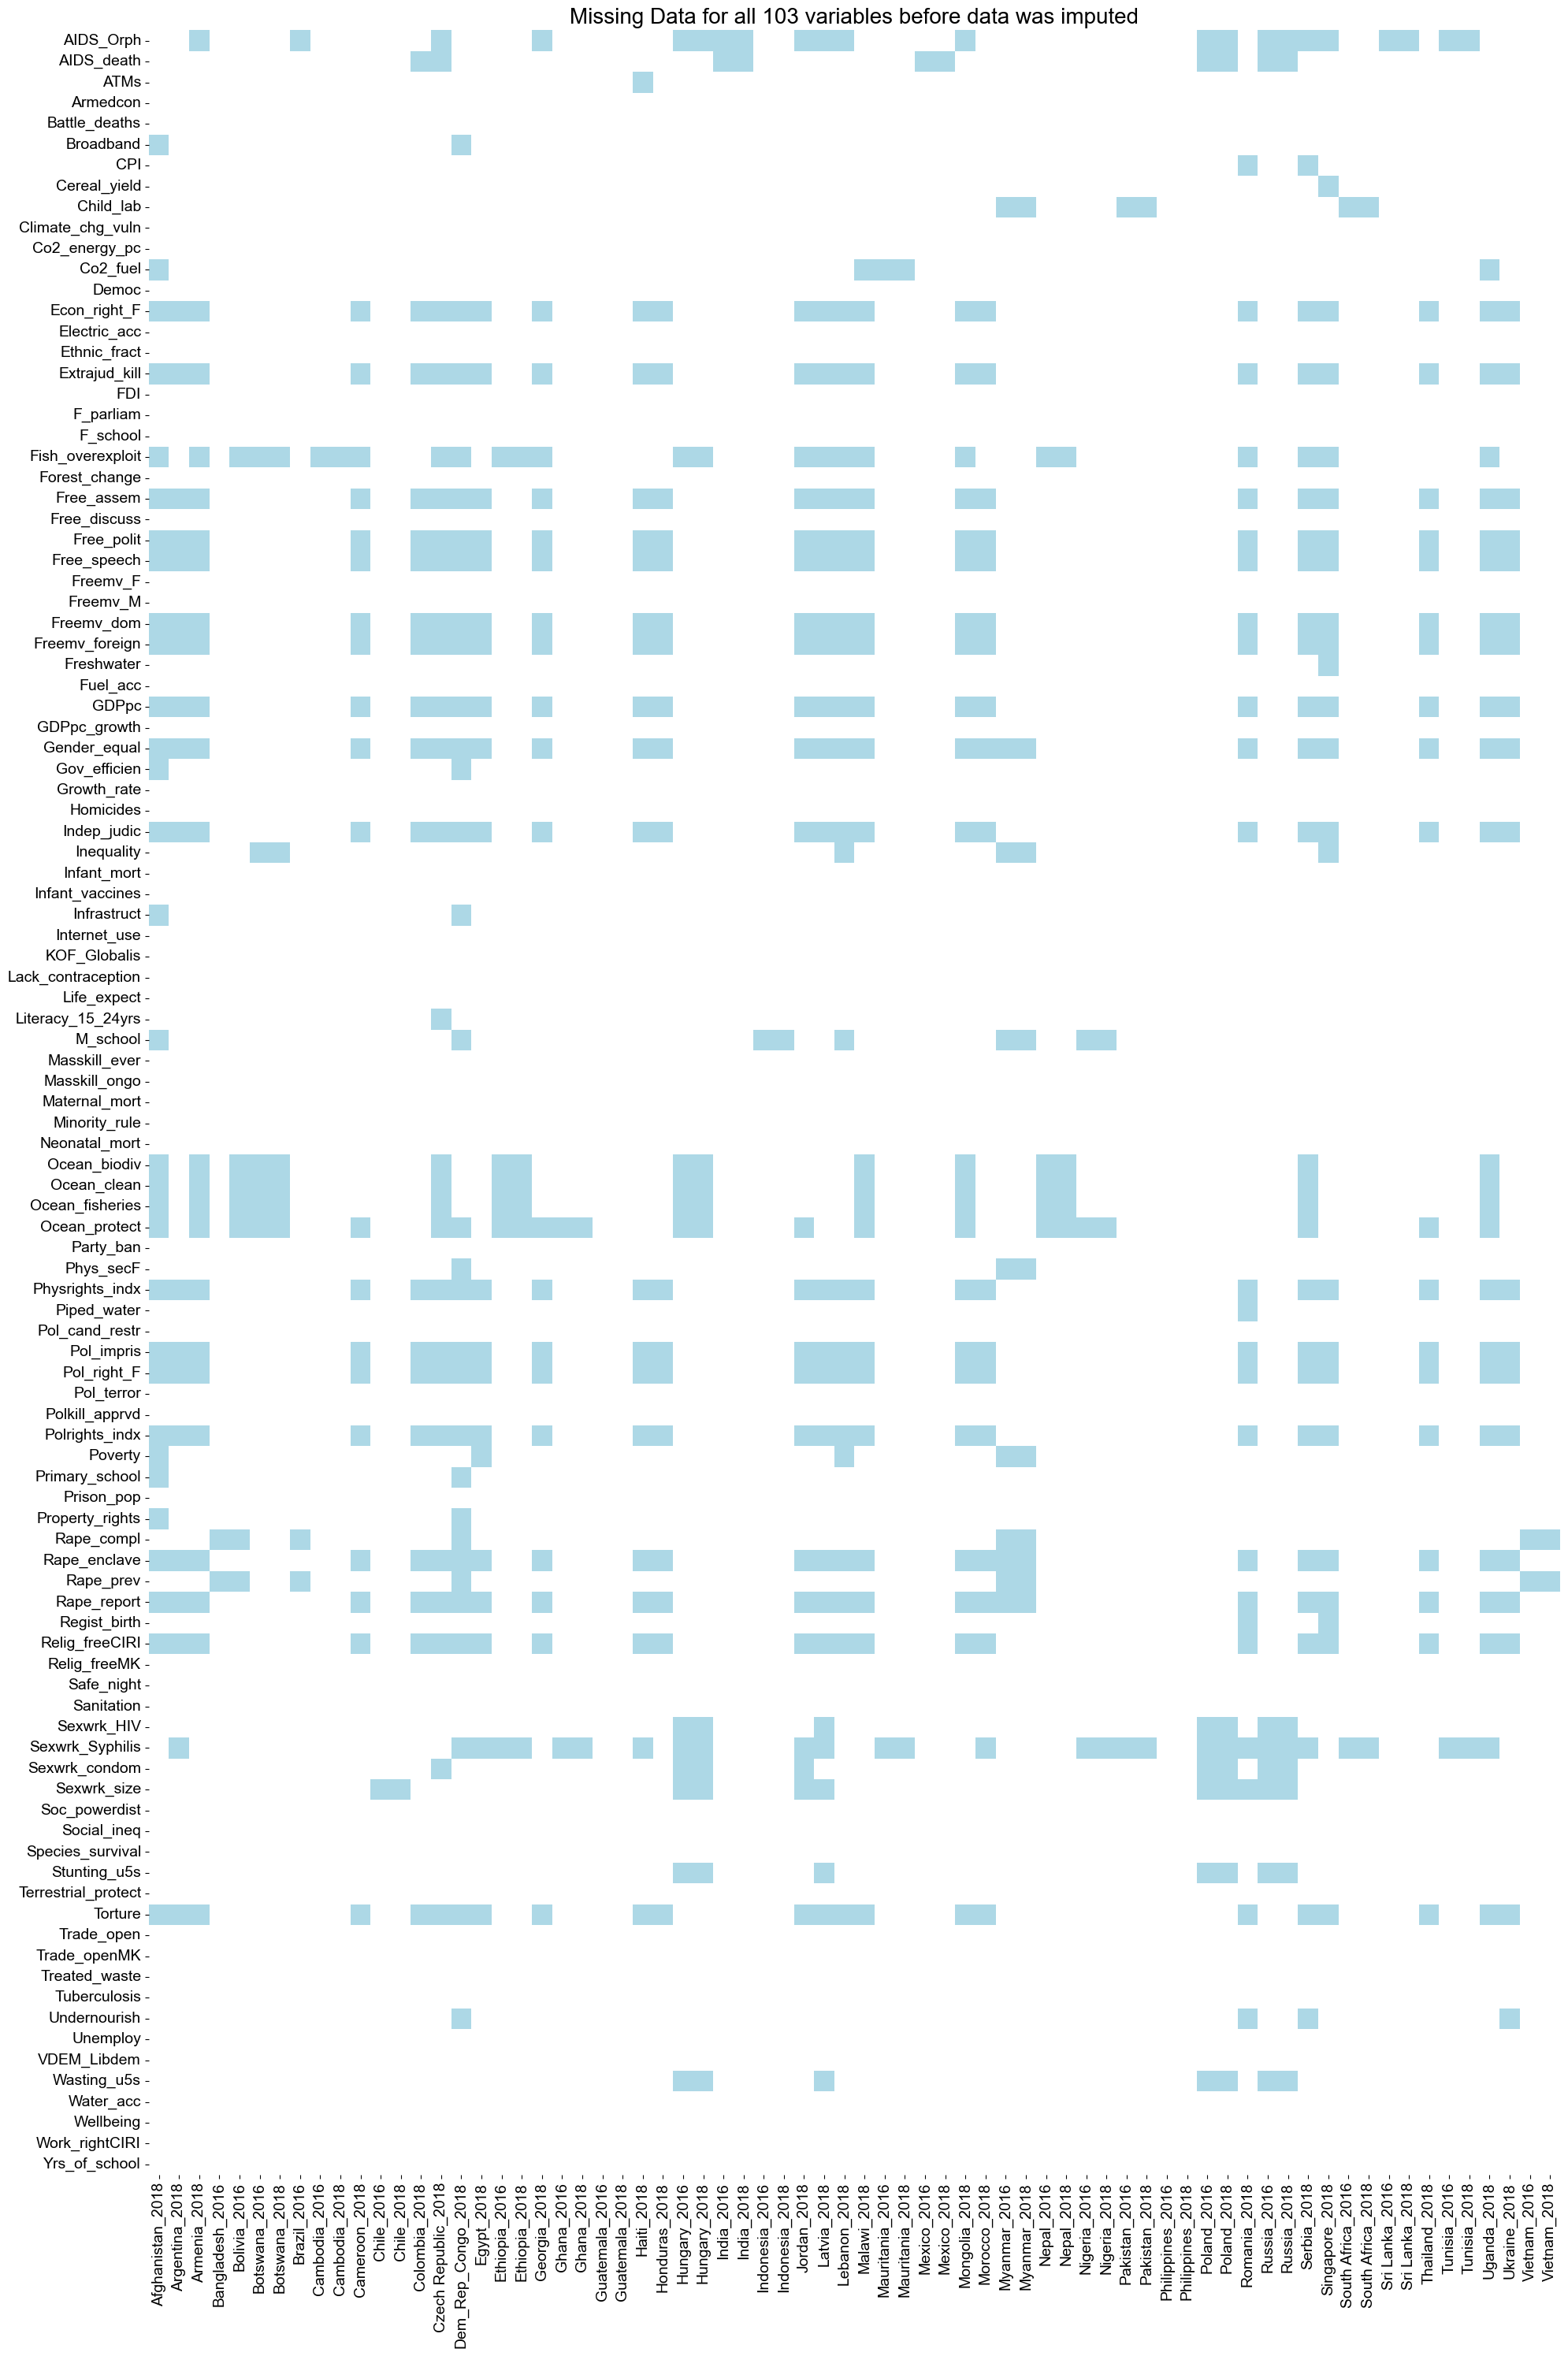

In [9]:
y = training.loc[:, training.columns=='SLAVERY']
training = training.drop('SLAVERY', axis=1)
colours = ['white', 'lightblue']
f, ax = plt.subplots(figsize = (20,30))
sns.set_style("whitegrid")
plt.title('Missing Data for all 103 variables before data was imputed', size=20)
sns.heatmap(training.isnull().transpose(), cmap=sns.color_palette(colours), cbar=False)
plt.tick_params(labelsize=14)
plt.tight_layout()

The final step was to use a multivariate feature imputation method with regression trees for the remaining missing values.

In [10]:
impute_estimator = DecisionTreeRegressor(min_samples_leaf = 5, random_state = 0)
imp = IterativeImputer(sample_posterior=False, max_iter=5, tol=1e-2, estimator=impute_estimator, random_state=500)
training[:] = imp.fit_transform(training)
print(training[training.columns].isna().sum().sum())

0


Variables were then normalised to be between between 0 and 1. The normalization was fit on training data and transformed both training and test independent variables.

In [11]:
# Training data normalization
r = (0, 1)
a = training.values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=r)
min_max_scaler.fit(a)
a = min_max_scaler.transform(a)
training = pd.DataFrame(a, columns=training.columns, index=training.index)
# Test data normalization
y_pred = OOS_Data['SLAVERY']
OOS_Data = OOS_Data.drop('SLAVERY', axis=1)
a = OOS_Data.values
a = min_max_scaler.transform(a)
OOS_Data = pd.DataFrame(a, columns=OOS_Data.columns, index=OOS_Data.index)
training['SLAVERY'] = y
OOS_Data['SLAVERY'] = y_pred

After Data Preprocessing is done, three models were trained to predict slavery prevalence. These models are:

* A linear regression model.
* A decision tree.
* A random forest.

Because the slavery indicator refers to either 2016 or 2018, each forementioned model was trained both on data up to 2016 to predict slavery prevalence for 2016 and on data between 2016 and 2019 to predict slavery prevalence for 2018.

All models are evaluated using the `Out of Sample data` and the Mean Absolute Error (MAE) as evaluation metric.

### Q2: Slavery Estimation Using All Features

Firtly, the forementioned models were trained on the dataset using all features. For that purpose, both training and test data are splitted across the forementioned time periods (2016 and 2018).

In [12]:
training_2016 = training.filter(regex='_2016', axis=0)
training_2018 = training.filter(regex='_2018', axis=0)
OOS_2016 = OOS_Data.filter(regex='_2016', axis=0)
OOS_2018 = OOS_Data.filter(regex='_2018', axis=0)

#### 2016 models

For the 2016 dataset, I splitted the features (for both train and test data) on the dependent variable (Slavery Prevalence) and independent variables.

In [13]:
y_test = OOS_2016['SLAVERY']
X_test = OOS_2016.loc[:, OOS_2016.columns != 'SLAVERY']
y = training_2016.SLAVERY
X = training_2016.loc[:, training_2016.columns != 'SLAVERY']

##### Linear Regression

Because the Residual Degrees of Freedom are equal to 0, we cannot gain information from the Adj. R-squared of the model, the existence or not of variable multicollinearity and the significance of the variables (p-value). 

For precise coefficient estimates and powerful hypothesis tests in regression, we must have many error degrees of freedom, which equates to having many observations for each model term. In our case, we have 104 terms (including Intercept) for 25 observations. As terms are being added to the model, the error degrees of freedom decreases, resulting to reduced precision of the estimates and the power of the tests. When we have too few remaining Degrees of Freedom, we cannot trust the regression results.

We can also securely mention that the model is overfitted, which is not desirable when we want to predict, as our model describes well the standard errors of the affected coefficients (which in our case tend to be large), but fails in that way to predict the behaviour of future observations.

The only way to comment on the importance of the features on predicting slavery prevalence, although it incorporates multicollinear effects, is their coefficient:

We cannot trust the exact value of the coefficients, however we can mention that the features printed below are the features that seem to be the most significant features of the model (I am not writing the exact features because every time the Notebook is rerun result in different imputation values, thus changing the order of the significance of the variables).

The following was produced using OLS function of the `Statsmodels` library.


Mean Absolute Error evaluation on Out of Sample Data is: 0.536760920644268

The most important features are:

Feature 0 : Free_polit 	 Coefficient: 0.36123902514381934
Feature 1 : Species_survival 	 Coefficient: 0.2550784394000253
Feature 2 : Masskill_ever 	 Coefficient: 0.24023421519513566
Feature 3 : Phys_secF 	 Coefficient: 0.23720064597086254
Feature 4 : Climate_chg_vuln 	 Coefficient: 0.21369422204876234
Feature 5 : Free_discuss 	 Coefficient: -0.21090636245645855
Feature 6 : F_school 	 Coefficient: -0.20548427429159621
Feature 7 : Rape_report 	 Coefficient: 0.1967646311339149
Feature 8 : Co2_energy_pc 	 Coefficient: 0.18772489780942683
Feature 9 : Indep_judic 	 Coefficient: -0.177851088647339
Feature 10 : Wellbeing 	 Coefficient: -0.17585295999223888
Feature 11 : Tuberculosis 	 Coefficient: 0.17280421973836632
Feature 12 : Ocean_clean 	 Coefficient: 0.17117669939626048
Feature 13 : Undernourish 	 Coefficient: -0.16450089808877627
Feature 14 : Ocean_protect 	 Coefficient: -0.1610

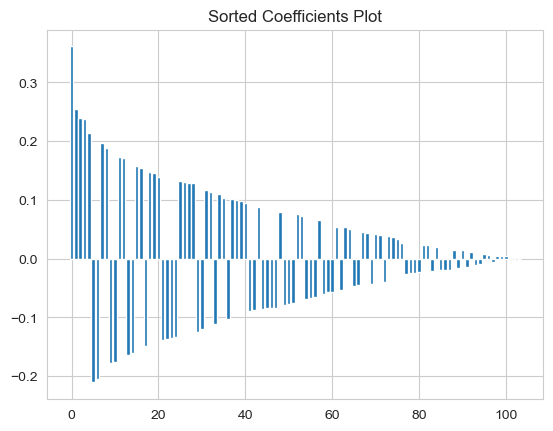

In [14]:
independent_variables = ' + '.join(training.columns[:-1])
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
# print(vif_data)
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2016)
ols_full_res = ols_full.fit()
# print()
# print(ols_full_res.summary())
y_pred = ols_full_res.predict(X_test)
MAE_ols_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_ols_2016)
# get importance
importance = ols_full_res.params
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\t Coefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Ridge Regression with Cross-Validation. 

When applying Ridge Regression, the optimized penalty coefficient is needed to be found, which is represented by alpha. The higher the alpha gets, the stronger becomes the penalty for coefficients. In a dataset that could have suffered from overfitting, Ridge Regression achieves to avoid that and fit the model to the signal and not the noise.

The Mean Absolute Error is much better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.3031765289880392

The most important features are:

Feature 0 : Indep_judic 	Coefficient: -0.012251003080799
Feature 1 : Minority_rule 	Coefficient: 0.011754317020463744
Feature 2 : Stunting_u5s 	Coefficient: 0.011547311300135494
Feature 3 : Internet_use 	Coefficient: -0.011532831864430059
Feature 4 : Phys_secF 	Coefficient: 0.010989265553375881
Feature 5 : Climate_chg_vuln 	Coefficient: 0.010831066607925542
Feature 6 : GDPpc 	Coefficient: -0.010648510633580568
Feature 7 : Freemv_F 	Coefficient: -0.010412856073743787
Feature 8 : Armedcon 	Coefficient: 0.010249281788600234
Feature 9 : Electric_acc 	Coefficient: -0.010032594608594752
Feature 10 : Fuel_acc 	Coefficient: -0.00975129573209636
Feature 11 : Wellbeing 	Coefficient: -0.009616397443237506
Feature 12 : Free_discuss 	Coefficient: -0.009615969249361964
Feature 13 : VDEM_Libdem 	Coefficient: -0.00936792726938983
Feature 14 : F_school 	Coefficient: -0.00931739452855909
Featu

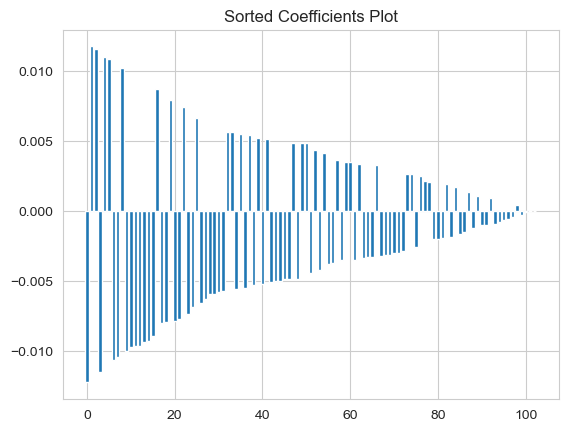

In [15]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ridge_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
print('\nThe most important features are:\n')
# summarize feature importance
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

Lasso Regression is a popular type of regularized linear regression that includes a L1 penalty. This has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task. This penalty allows some coefficient values to go to the value of zero, allowing input variables to be effectively removed from the model, providing a type of automatic feature selection.

Contrary to Ridge Regression, which applies a penalty to "bad" variables, but not setting their covariates to 0, thus being in compliance with the assumption of using all variables, Lasso sets variables equal to 0, thus reducing the model's dimensions. Although, the prediction of slavery estimation by the use of all features is needed, we can use Lasso to indicate the important variables for prediction.

The most important features of this model are printed below.

The Mean Absolute Error is even better compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.25006862425104043

The most important features are:

Feature 0 : Wellbeing 	Coefficient: -0.1998124678100344
Feature 1 : Free_discuss 	Coefficient: -0.19094238653638806
Feature 2 : Phys_secF 	Coefficient: 0.16343975496773408
Feature 3 : F_school 	Coefficient: -0.12971897944099284
Feature 4 : Climate_chg_vuln 	Coefficient: 0.11701044987872893
Feature 5 : Indep_judic 	Coefficient: -0.09558286724279148
Feature 6 : M_school 	Coefficient: -0.08775324223694185
Feature 7 : Free_polit 	Coefficient: 0.08697702945681936
Feature 8 : Stunting_u5s 	Coefficient: 0.08373547053412778
Feature 9 : Armedcon 	Coefficient: 0.050068227245396585
Feature 10 : Minority_rule 	Coefficient: 0.03038348144193538
Feature 11 : Internet_use 	Coefficient: -0.01832859920344635
Feature 12 : Rape_report 	Coefficient: 0.007941026417930892
Feature 13 : Poverty 	Coefficient: -0.0
Feature 14 : Rape_compl 	Coefficient: 0.0
Feature 15 : Prison_pop 	Coefficient: -0.0
Fe

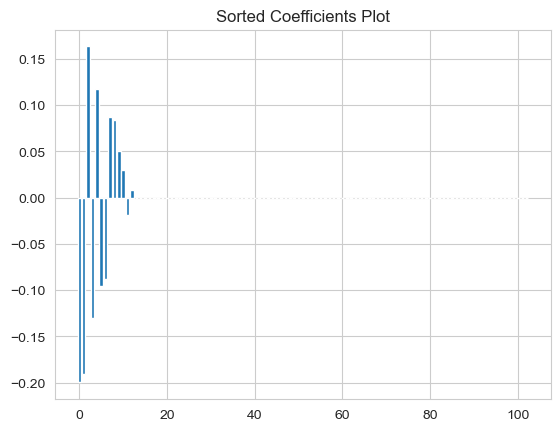

In [16]:
reg = linear_model.Lasso(alpha=0.069) # all coefficients zero
reg = linear_model.Lasso(alpha=0.021)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_lasso_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

Decision tree regression observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output.

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [17]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.31870855148342053


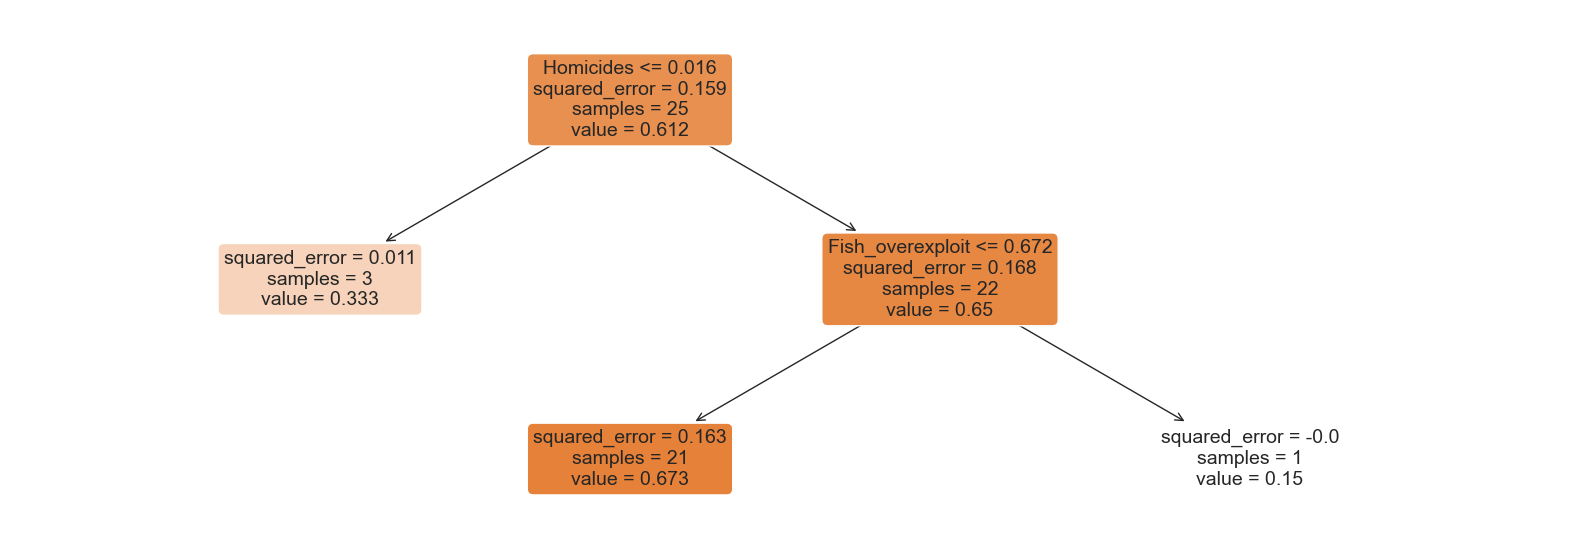

In [18]:
tree_regr = DecisionTreeRegressor(ccp_alpha=0.01, max_depth=2, max_features='log2',
                      splitter='random', random_state=6)
tree_regr.fit(X, y)
# print(tree_regr)
y_pred = tree_regr.predict(X_test)
MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_tree_2016)
# print(tree_regr.get_depth())
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(tree_regr, 
                   feature_names=training_2016.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

Every decision tree has high variance, but when we combine all of them together in parallel then the resultant variance is low as each decision tree gets perfectly trained on that particular sample data, and hence the output doesn’t depend on one decision tree but on multiple decision trees. 

Random Forest is an ensemble technique that uses multiple decision trees and a technique called Bootstrap and Aggregation, commonly known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. 

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error of the Random Forest is better than the Decision Tree's respective one, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [19]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.28671619384879743

The most important features are:
(The features that have 0 value were not used)

1. feature 19 F_school (0.046192)
2. feature 23 Free_discuss (0.045845)
3. feature 43 Internet_use (0.037259)
4. feature 7 Cereal_yield (0.029776)
5. feature 70 Prison_pop (0.029320)
6. feature 46 Life_expect (0.028874)
7. feature 53 Neonatal_mort (0.026353)
8. feature 102 Yrs_of_school (0.025680)
9. feature 98 Wasting_u5s (0.025212)
10. feature 6 CPI (0.023311)
11. feature 32 GDPpc (0.022947)
12. feature 5 Broadband (0.022797)
13. feature 9 Climate_chg_vuln (0.022389)
14. feature 14 Electric_acc (0.020871)
15. feature 97 VDEM_Libdem (0.020361)
16. feature 51 Maternal_mort (0.019302)
17. feature 57 Ocean_protect (0.018741)
18. feature 44 KOF_Globalis (0.017858)
19. feature 21 Forest_change (0.016229)
20. feature 82 Sexwrk_Syphilis (0.016059)
21. feature 40 Infant_mort (0.015837)
22. feature 65 Pol_terror (0.015604)
23. feature 4

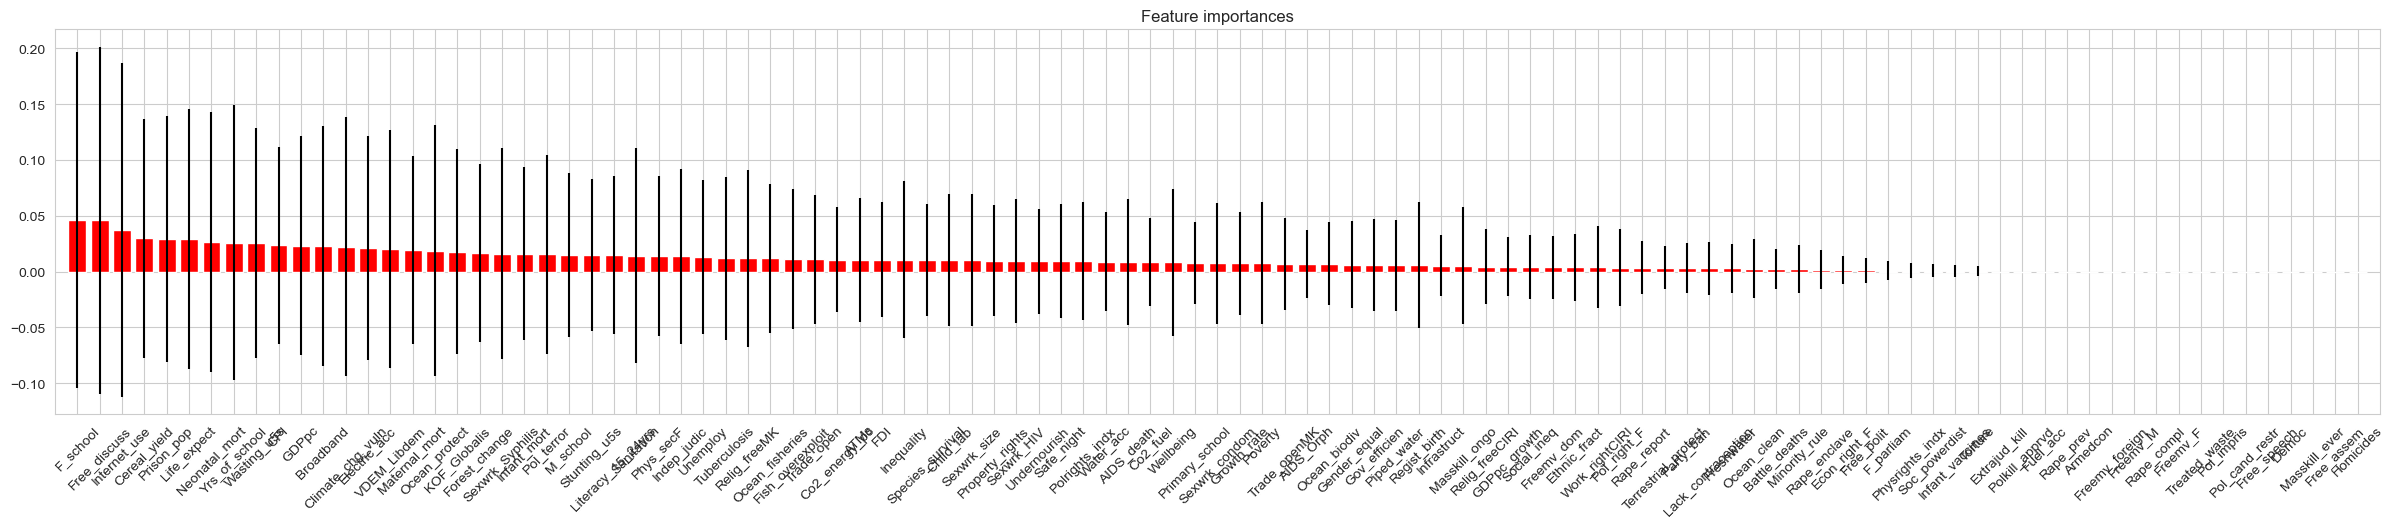

In [20]:
regr = RandomForestRegressor(ccp_alpha=0.01, max_depth=4, max_features='log2', random_state=7)
regr.fit(X, y)
# print(regr)
y_pred = regr.predict(X_test)
MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_forest_2016)
print('\nThe most important features are:\n(The features that have 0 value were not used)\n')
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(30, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

#### 2018 models

For the 2018 dataset, I splitted the features (for both train and test data) on the dependent variable (Slavery Prevalence) and independent variables.

In [21]:
y_test = OOS_2018['SLAVERY']
X_test = OOS_2018.loc[:, OOS_2018.columns != 'SLAVERY']
y = training_2018.SLAVERY
X = training_2018.loc[:, training_2018.columns != 'SLAVERY']

##### Linear Regression

The same as previously regarding the Residual Degrees of Freedom is also applied on the 2018 model.
Because the Residual Degrees of Freedom are equal to 0, we cannot gain information from the Adj. R-squared of the model, the existence or not of variable multicollinearity and the significance of the variables (p-value). 

For precise coefficient estimates and powerful hypothesis tests in regression, we must have many error degrees of freedom, which equates to having many observations for each model term. In our case, we have 104 terms (including Intercept) for 45 observations. As terms are being added to the model, the error degrees of freedom decreases, resulting to reduced precision of the estimates and the power of the tests. When we have too few remaining Degrees of Freedom, we cannot trust the regression results.

We can also securely mention that the model is overfitted, which is not desirable when we want to predict, as our model describes well the standard errors of the affected coefficients (which in our case tend to be large), but fails in that way to predict the behaviour of future observations.

The only way to comment on the importance of the features on predicting slavery prevalence, although it incorporates multicollinear effects, is their coefficient:

We cannot trust the exact value of the coefficients, however we can mention that the features printed below are the features that seem to be the most significant features of the model (I am not writing the exact features because every time the Notebook is rerun result in different imputation values, thus changing the order of the significance of the variables).

The following was produced using OLS function of the `Statsmodels` library.


Mean Absolute Error evaluation on Out of Sample Data is: 0.5320045467380722


The most important features are:

Feature 0 : Free_discuss 	Coefficient: -0.37879887012350033
Feature 1 : Tuberculosis 	Coefficient: 0.36921714962023233
Feature 2 : Forest_change 	Coefficient: 0.3500558226327937
Feature 3 : Poverty 	Coefficient: -0.33486208023273417
Feature 4 : Relig_freeMK 	Coefficient: -0.32296242219274945
Feature 5 : Battle_deaths 	Coefficient: 0.31097405129673106
Feature 6 : Climate_chg_vuln 	Coefficient: 0.2968451422149048
Feature 7 : Party_ban 	Coefficient: 0.29673047172235617
Feature 8 : Infant_vaccines 	Coefficient: 0.2941870671308091
Feature 9 : Species_survival 	Coefficient: 0.27123971343898545
Feature 10 : Safe_night 	Coefficient: -0.2519326170122662
Feature 11 : Rape_enclave 	Coefficient: -0.24207666866085797
Feature 12 : Social_ineq 	Coefficient: -0.23589108016438814
Feature 13 : Primary_school 	Coefficient: -0.23367232665459306
Feature 14 : Stunting_u5s 	Coefficient: 0.23342375

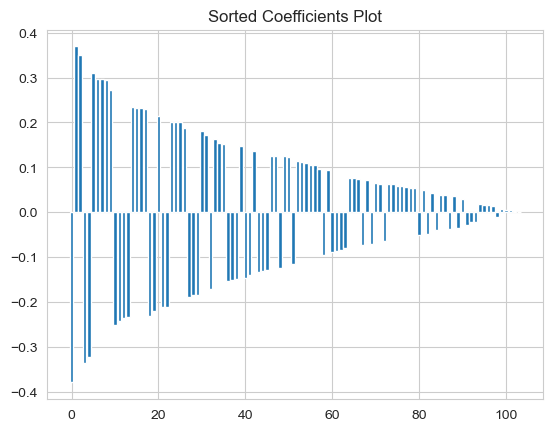

In [22]:
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2018)
ols_full_res = ols_full.fit()
# ols_full_res.summary()
y_pred = ols_full_res.predict(X_test)
MAE_ols_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ols_2018)
print()
# get importance
importance = ols_full_res.params
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Ridge Regression with Cross-Validation. 

The Mean Absolute Error is better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.38464597853168025

The most important features are:

Feature 0 : Minority_rule 	Coefficient: 0.10682994710815322
Feature 1 : Water_acc 	Coefficient: -0.09112266241457903
Feature 2 : Masskill_ongo 	Coefficient: 0.08562240193794601
Feature 3 : Rape_enclave 	Coefficient: -0.08458493305664024
Feature 4 : Relig_freeMK 	Coefficient: -0.0775246550774862
Feature 5 : Battle_deaths 	Coefficient: 0.07539814550845234
Feature 6 : Climate_chg_vuln 	Coefficient: 0.07172058477344238
Feature 7 : Free_discuss 	Coefficient: -0.0715880124628492
Feature 8 : Forest_change 	Coefficient: 0.0711730826481276
Feature 9 : Inequality 	Coefficient: -0.06602818427843116
Feature 10 : Fuel_acc 	Coefficient: -0.06399547204066693
Feature 11 : Neonatal_mort 	Coefficient: 0.06277528555686587
Feature 12 : Ocean_protect 	Coefficient: 0.06270252978880503
Feature 13 : Safe_night 	Coefficient: -0.06256490988464038
Feature 14 : Electric_acc 	Coefficient: -0.06143975473

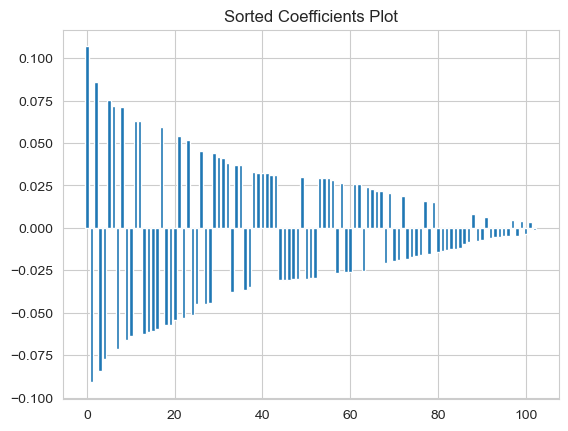

In [23]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ridge_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

The most important features of this model are printed below.

The Mean Absolute Error is even better compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.328918318536278

The most important features are:

Feature 0 : Water_acc 	Coefficient: -0.4749377659260169
Feature 1 : Minority_rule 	Coefficient: 0.18673436649469505
Feature 2 : Masskill_ongo 	Coefficient: 0.1569199614846423
Feature 3 : Internet_use 	Coefficient: -0.10098592765618876
Feature 4 : Fuel_acc 	Coefficient: -0.06447214143465196
Feature 5 : GDPpc 	Coefficient: -0.028781956479924268
Feature 6 : Freemv_F 	Coefficient: -0.023276026048510076
Feature 7 : Relig_freeMK 	Coefficient: -0.021385733711898638
Feature 8 : Literacy_15_24yrs 	Coefficient: -0.013557790293531893
Feature 9 : Property_rights 	Coefficient: -0.0
Feature 10 : Primary_school 	Coefficient: -0.0
Feature 11 : Prison_pop 	Coefficient: -0.0
Feature 12 : AIDS_Orph 	Coefficient: -0.0
Feature 13 : Rape_compl 	Coefficient: 0.0
Feature 14 : Rape_enclave 	Coefficient: -0.0
Feature 15 : Polrights_indx 	Coefficient: -0.0
Feature 16 : Poverty 	Coefficient: -0.0
Feature

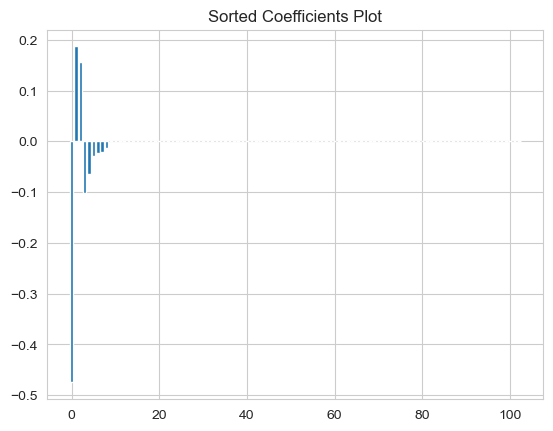

In [24]:
reg = linear_model.Lasso(alpha=0.113) # all coefficients zero = 0.4310284237726099
reg = linear_model.Lasso(alpha=0.034)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_lasso_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [25]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2018)


Mean Absolute Error evaluation on Out of Sample Data is: 0.3547093023255814


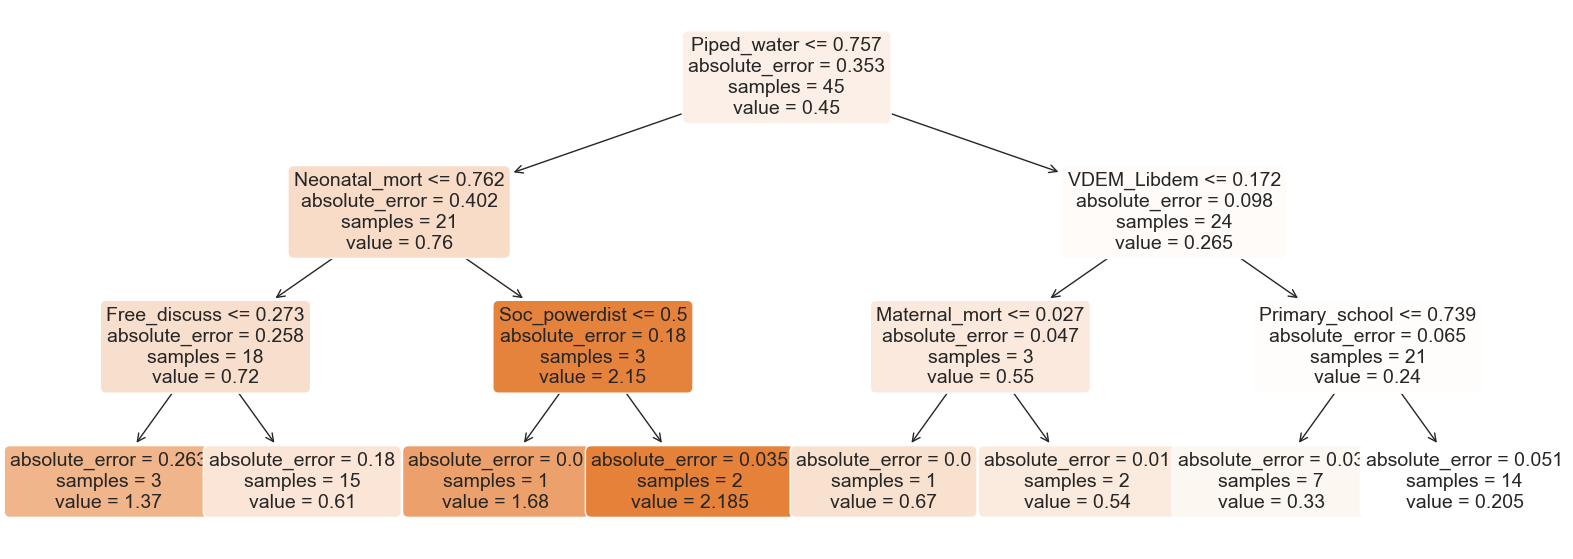

In [26]:
clf = DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=10)
clf = clf.fit(X, y)
y_pred = clf.predict(X_test)
MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_tree_2018)
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(clf, 
                   feature_names=training_2018.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is on average better than Decision Tree's, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [27]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2018)


Mean Absolute Error evaluation on Out of Sample Data is: 0.33941453488372103

The most important features are:
(The features that have 0 value were not used)

1. feature 94 Tuberculosis (0.117973)
2. feature 53 Neonatal_mort (0.114957)
3. feature 61 Piped_water (0.110611)
4. feature 69 Primary_school (0.049125)
5. feature 43 Internet_use (0.047746)
6. feature 23 Free_discuss (0.029506)
7. feature 19 F_school (0.023658)
8. feature 48 M_school (0.023000)
9. feature 102 Yrs_of_school (0.018619)
10. feature 32 GDPpc (0.018271)
11. feature 6 CPI (0.017930)
12. feature 4 Battle_deaths (0.017080)
13. feature 99 Water_acc (0.015952)
14. feature 40 Infant_mort (0.015716)
15. feature 98 Wasting_u5s (0.014604)
16. feature 84 Sexwrk_size (0.013936)
17. feature 47 Literacy_15_24yrs (0.013588)
18. feature 71 Property_rights (0.012663)
19. feature 46 Life_expect (0.012308)
20. feature 100 Wellbeing (0.011722)
21. feature 31 Fuel_acc (0.011343)
22. feature 97 VDEM_Libdem (0.010778)
23. feature 51 Mat

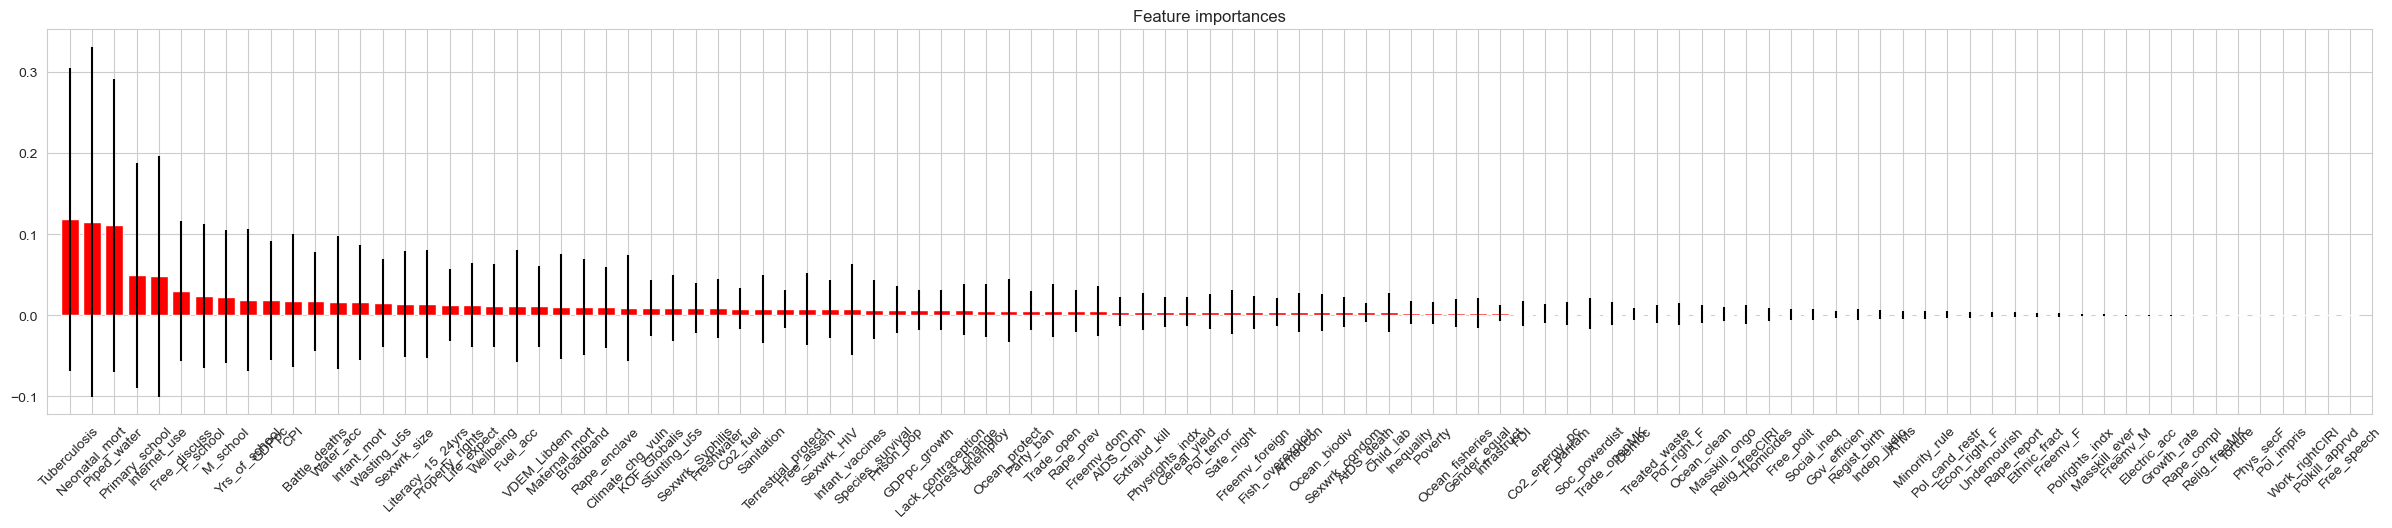

In [28]:
regr = RandomForestRegressor(criterion='absolute_error', max_depth=3, random_state=7)
regr = regr.fit(X, y)
# scores = cross_val_score(regr, X, y, cv=5)
# print(scores.mean())
y_pred = regr.predict(X_test)
MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_forest_2018)
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print('\nThe most important features are:\n(The features that have 0 value were not used)\n')
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(30, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

In [29]:
print_full1 = 'Final Comparison between 2016 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2016) + '\nRidge:\t' + str(MAE_ridge_2016) + '\nLasso:\t' + str(MAE_lasso_2016) + '\nTree:\t' + str(MAE_tree_2016) + '\nForest:\t' + str(MAE_forest_2016)
print_full2 = '\n\nFinal Comparison between 2018 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2018) + '\nRidge:\t' + str(MAE_ridge_2018) + '\nLasso:\t' + str(MAE_lasso_2018) + '\nTree:\t' + str(MAE_tree_2018) + '\nForest:\t' + str(MAE_forest_2018)
print_full = print_full1 + print_full2
print(print_full)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	0.536760920644268
Ridge:	0.3031765289880392
Lasso:	0.25006862425104043
Tree:	0.31870855148342053
Forest:	0.28671619384879743

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.5320045467380722
Ridge:	0.38464597853168025
Lasso:	0.328918318536278
Tree:	0.3547093023255814
Forest:	0.33941453488372103


### Q3: Slavery Estimation with Theory-based Features

Then, the forementioned models were trained on the dataset using Theory-based Features. For that purpose, both training and test data are splitted across the forementioned time periods (2016 and 2018).

In [30]:
keep_vars = ['KOF_Globalis','Work_rightCIRI','Trade_open','GDPpc',
 'Armedcon','Poverty', 'Stunting_u5s','Undernourish','Wasting_u5s','Maternal_mort',
 'Neonatal_mort','Literacy_15_24yrs','F_school','ATMs','Child_lab','Unemploy','Infrastruct',
 'Internet_use','Broadband','Climate_chg_vuln','CPI','Minority_rule','Freemv_M',
 'Freemv_F','Free_discuss','Soc_powerdist','Democ',
 'Sexwrk_condom','Sexwrk_Syphilis','AIDS_Orph','Rape_report',
 'Rape_enclave','Phys_secF','Gender_equal','SLAVERY']

training_2016 = training_2016.loc[:,keep_vars]
training_2018 = training_2018.loc[:,keep_vars]
OOS_2016 = OOS_2016.loc[:,keep_vars]
OOS_2018 = OOS_2018.loc[:,keep_vars]

#### 2016 models

For the 2016 dataset, I splitted the features (for both train and test data) on the dependent variable (Slavery Prevalence) and independent variables.

In [31]:
y_test = OOS_2016['SLAVERY']
X_test = OOS_2016.loc[:, OOS_2016.columns != 'SLAVERY']
y = training_2016.SLAVERY
X = training_2016.loc[:, training_2016.columns != 'SLAVERY']

##### Linear Regression

Because the Residual Degrees of Freedom are equal to 0, we cannot gain information from the Adj. R-squared of the model, the existence or not of variable multicollinearity and the significance of the variables (p-value). 

For precise coefficient estimates and powerful hypothesis tests in regression, we must have many error degrees of freedom, which equates to having many observations for each model term. In our case, we have 35 terms (including Intercept) for 25 observations. As terms are being added to the model, the error degrees of freedom decreases, resulting to reduced precision of the estimates and the power of the tests. When we have too few remaining Degrees of Freedom, we cannot trust the regression results.

We can also securely mention that the model is overfitted, which is not desirable when we want to predict, as our model describes well the standard errors of the affected coefficients (which in our case tend to be large), but fails in that way to predict the behaviour of future observations.

The only way to comment on the importance of the features on predicting slavery prevalence, although it incorporates multicollinear effects, is their coefficient:

We cannot trust the exact value of the coefficients, however we can mention that the features printed below are the features that seem to be the most significant features of the model (I am not writing the exact features because every time the Notebook is rerun result in different imputation values, thus changing the order of the significance of the variables).

The following was produced using OLS function of the `Statsmodels` library.


Mean Absolute Error evaluation on Out of Sample Data is: 1.0564987387528428

The most important features are:

Feature 0 : Climate_chg_vuln 	Coefficient: 1.5770683084897197
Feature 1 : CPI 	Coefficient: -1.4294245452581007
Feature 2 : Intercept 	Coefficient: -1.389520462697031
Feature 3 : Stunting_u5s 	Coefficient: 1.2291108661241252
Feature 4 : AIDS_Orph 	Coefficient: -1.2051477318897135
Feature 5 : F_school 	Coefficient: -1.1018354377861024
Feature 6 : Broadband 	Coefficient: 1.0255995683191885
Feature 7 : Undernourish 	Coefficient: -1.0194667873521672
Feature 8 : Internet_use 	Coefficient: 1.0180122598934425
Feature 9 : Literacy_15_24yrs 	Coefficient: 0.9155852716092229
Feature 10 : Poverty 	Coefficient: 0.9011282160219861
Feature 11 : Unemploy 	Coefficient: 0.8186274598896643
Feature 12 : Rape_report 	Coefficient: 0.7266802204214584
Feature 13 : Freemv_F 	Coefficient: 0.7260234832841277
Feature 14 : Democ 	Coefficient: 0.6730259476766364
Feature 15 : KOF_Globalis 	Coefficient: -0.

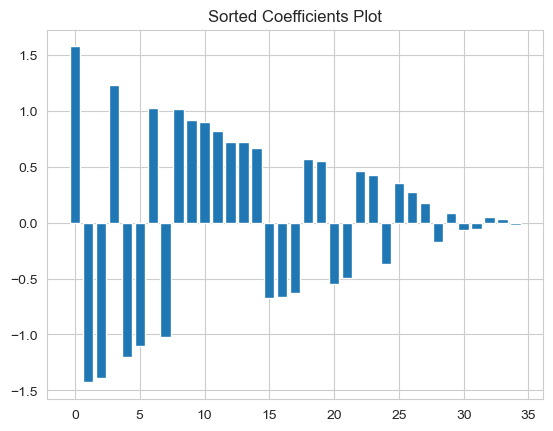

In [32]:
independent_variables = ' + '.join(training_2016.columns[:-1])
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2016)
ols_full_res = ols_full.fit()
# print(ols_full_res.summary())
y_pred = ols_full_res.predict(X_test)
MAE_ols_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ols_2016)
# get importance
importance = ols_full_res.params
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Ridge Regression with Cross-Validation. 

The Mean Absolute Error is better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.24919838587440732

The most important features are:

Feature 0 : Phys_secF 	Coefficient: 0.06910376011384067
Feature 1 : Climate_chg_vuln 	Coefficient: 0.06617369661708392
Feature 2 : Free_discuss 	Coefficient: -0.061368634543356365
Feature 3 : Internet_use 	Coefficient: -0.06047529803093257
Feature 4 : F_school 	Coefficient: -0.05911847555576004
Feature 5 : Stunting_u5s 	Coefficient: 0.05843998029632096
Feature 6 : Minority_rule 	Coefficient: 0.05625071450711201
Feature 7 : GDPpc 	Coefficient: -0.04832801086893964
Feature 8 : AIDS_Orph 	Coefficient: -0.04664331585614523
Feature 9 : Armedcon 	Coefficient: 0.04657414974368179
Feature 10 : Rape_report 	Coefficient: 0.045786541056251226
Feature 11 : Neonatal_mort 	Coefficient: 0.043260903906167915
Feature 12 : Democ 	Coefficient: -0.03492328946696153
Feature 13 : CPI 	Coefficient: -0.030469801807137768
Feature 14 : Freemv_F 	Coefficient: -0.027984816119669013
Feature 15 : Wasting

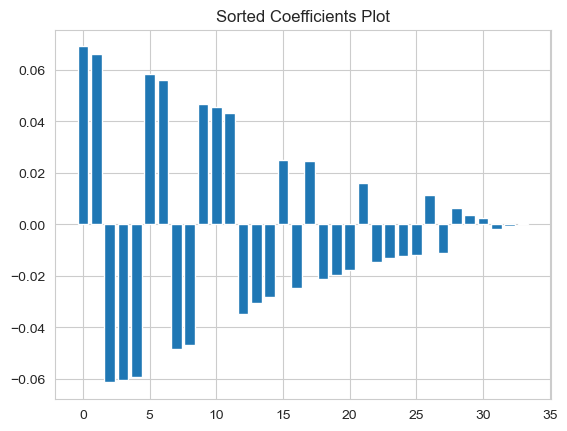

In [33]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_ridge_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

The most important features of this model are printed below.

The Mean Absolute Error is worse compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.26462964376069115

The most important features are:

Feature 0 : Climate_chg_vuln 	Coefficient: 0.3003956429902774
Feature 1 : Phys_secF 	Coefficient: 0.184574874184608
Feature 2 : F_school 	Coefficient: -0.14056399821787796
Feature 3 : Free_discuss 	Coefficient: -0.10583922659197743
Feature 4 : Internet_use 	Coefficient: -0.07785665710541717
Feature 5 : Stunting_u5s 	Coefficient: 0.0682731477014352
Feature 6 : Minority_rule 	Coefficient: 0.035826499184502404
Feature 7 : Armedcon 	Coefficient: 0.03566516125619081
Feature 8 : Rape_report 	Coefficient: 0.03333279620895828
Feature 9 : AIDS_Orph 	Coefficient: -0.007982621786505599
Feature 10 : Freemv_M 	Coefficient: -0.0
Feature 11 : Freemv_F 	Coefficient: -0.0
Feature 12 : Sexwrk_condom 	Coefficient: -0.0
Feature 13 : Soc_powerdist 	Coefficient: 0.0
Feature 14 : Democ 	Coefficient: -0.0
Feature 15 : Sexwrk_Syphilis 	Coefficient: -0.0
Feature 16 : Rape_enclave 	Coefficient: -0.0
F

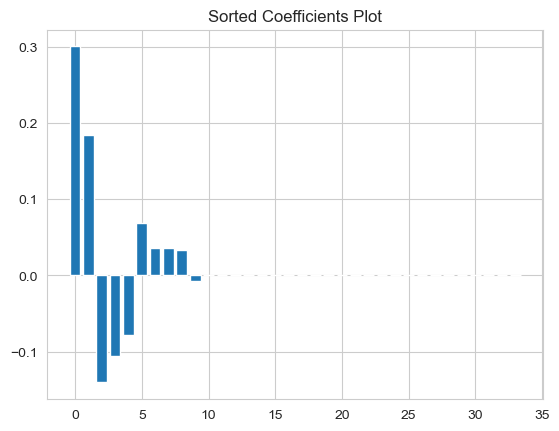

In [34]:
reg = linear_model.Lasso(alpha=0.067) # all coefficients zero
reg = linear_model.Lasso(alpha=0.021)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_lasso_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [35]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.31585369400814434


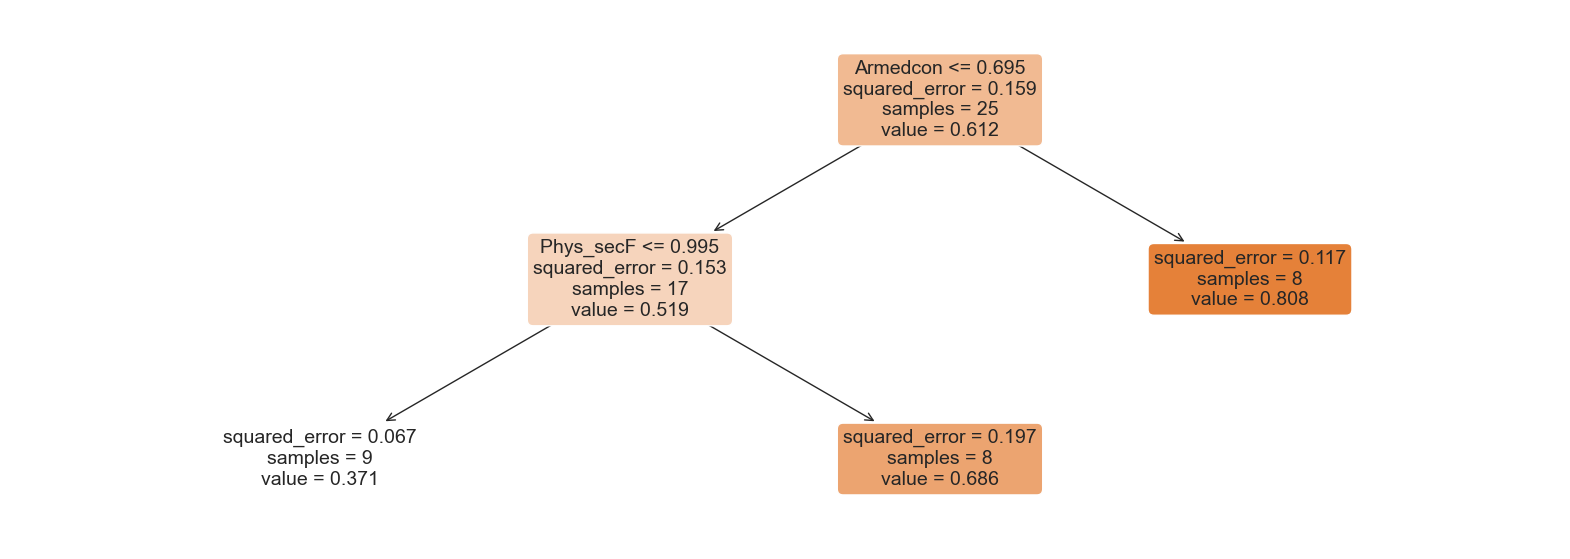

In [36]:
tree_regr = DecisionTreeRegressor(ccp_alpha=0.01, max_depth=2, max_features='log2', splitter='random', random_state=3)
tree_regr.fit(X, y)
# print(tree_regr)
y_pred = tree_regr.predict(X_test)
MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_tree_2016)
# print(tree_regr.get_depth())
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(tree_regr, 
                   feature_names=training_2016.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error of the Random Forest is better than the Decision Tree's respective one, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [37]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.2915819750372701

The most important features are:
(The features that have 0 value were not used)

1. feature 11 Literacy_15_24yrs (0.097508)
2. feature 28 Sexwrk_Syphilis (0.096611)
3. feature 6 Stunting_u5s (0.083760)
4. feature 20 CPI (0.081227)
5. feature 17 Internet_use (0.077346)
6. feature 24 Free_discuss (0.065246)
7. feature 19 Climate_chg_vuln (0.051587)
8. feature 3 GDPpc (0.050490)
9. feature 15 Unemploy (0.047584)
10. feature 18 Broadband (0.036469)
11. feature 8 Wasting_u5s (0.031788)
12. feature 0 KOF_Globalis (0.030983)
13. feature 9 Maternal_mort (0.030309)
14. feature 12 F_school (0.028470)
15. feature 13 ATMs (0.027678)
16. feature 16 Infrastruct (0.019385)
17. feature 29 AIDS_Orph (0.019118)
18. feature 10 Neonatal_mort (0.018499)
19. feature 5 Poverty (0.017593)
20. feature 33 Gender_equal (0.013372)
21. feature 30 Rape_report (0.013299)
22. feature 14 Child_lab (0.012519)
23. feature 27 Sexwrk_condom (0.0

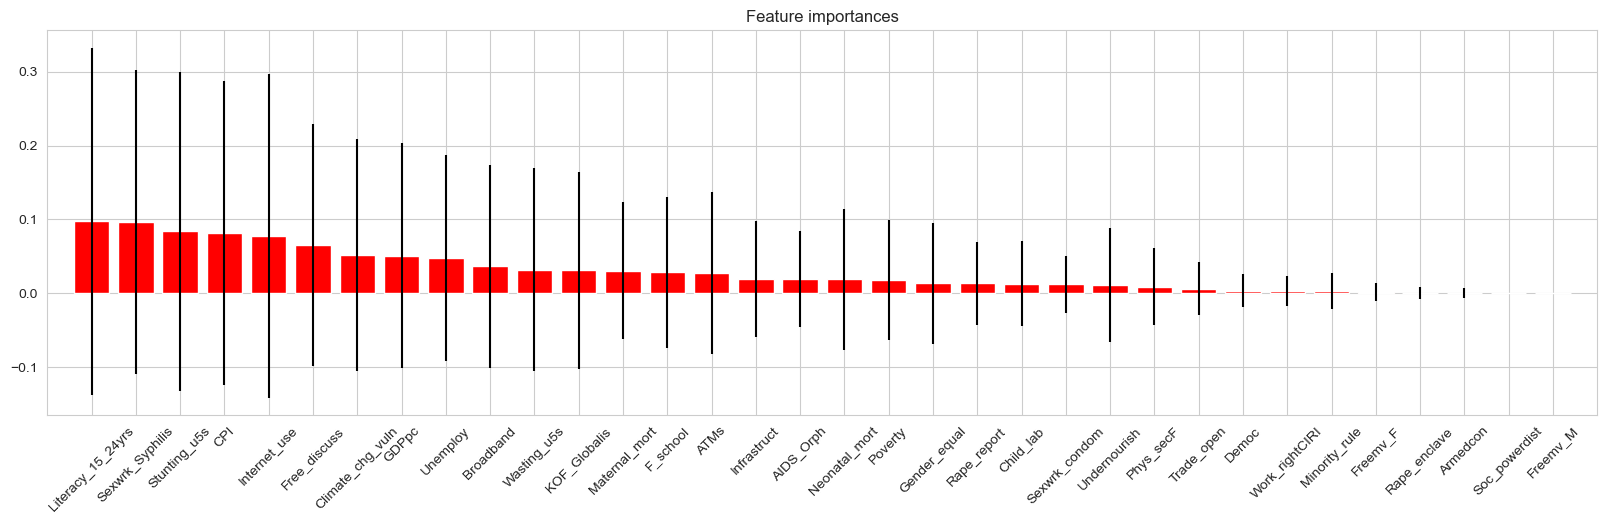

In [38]:
regr = RandomForestRegressor(ccp_alpha=0.01, max_depth=4, max_features='log2', random_state=7)
regr.fit(X, y)
# print(regr)
y_pred = regr.predict(X_test)
MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_forest_2016)
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print('\nThe most important features are:\n(The features that have 0 value were not used)\n')
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(20, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

#### 2018 models

For the 2018 dataset, I splitted the features (for both train and test data) on the dependent variable (Slavery Prevalence) and independent variables.

In [39]:
y_test = OOS_2018['SLAVERY']
X_test = OOS_2018.loc[:, OOS_2018.columns != 'SLAVERY']
y = training_2018.SLAVERY
X = training_2018.loc[:, training_2018.columns != 'SLAVERY']

##### Linear Regression

Because the multicollinearity (VIF) cannot be measured (divide by 0 -> vif = 1. / (1. - r_squared_i)), we do not trust the features' coefficients, cause there exists high multicollinearity among the 'independent' variables. 

We can also securely mention that the model is overfitted, which is not desirable when we want to predict, as our model describes well the standard errors of the affected coefficients (which in our case tend to be large), but fails in that way to predict the behaviour of future observations.

The only way to comment on the importance of the features on predicting slavery prevalence, although it incorporates multicollinear effects and is not statistically correct, is their p-value:

We cannot trust the exact value of the coefficients, however we can mention that the features printed below having a p-value below 0.05 can be considered as significant (I am not writing the exact features because every time the Notebook is rerun result in different imputation values, thus changing the order of the significance of the variables).

The following was produced using OLS function of the `Statsmodels` library.

In [40]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
# print(vif_data)
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2018)
ols_full_res = ols_full.fit()
print(ols_full_res.summary())
y_pred = ols_full_res.predict(X_test)
MAE_ols_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ols_2018)
# get importance
# importance = ols_full_res.params
# importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# # summarize feature importance
# for i in range(len(importance)):
#     print('Feature',i,':',importance.index[i],'Score:',importance[i])
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

                            OLS Regression Results                            
Dep. Variable:                SLAVERY   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     4.697
Date:                Mon, 27 Feb 2023   Prob (F-statistic):            0.00652
Time:                        23:39:33   Log-Likelihood:                 29.841
No. Observations:                  45   AIC:                             10.32
Df Residuals:                      10   BIC:                             73.55
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6689      1.01

I also applied Ridge Regression with Cross-Validation. 

The Mean Absolute Error is better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.5422500794419286

The most important features are:

Feature 0 : Sexwrk_Syphilis 	Coefficient: 0.32232953119299484
Feature 1 : Neonatal_mort 	Coefficient: 0.3086671140265351
Feature 2 : Literacy_15_24yrs 	Coefficient: -0.2816087191900881
Feature 3 : Rape_enclave 	Coefficient: -0.27550975377507764
Feature 4 : Poverty 	Coefficient: -0.2736676699652142
Feature 5 : Minority_rule 	Coefficient: 0.2724731384223744
Feature 6 : Work_rightCIRI 	Coefficient: 0.2507294840175477
Feature 7 : Climate_chg_vuln 	Coefficient: 0.24261881628841991
Feature 8 : Free_discuss 	Coefficient: -0.22789944388904948
Feature 9 : Trade_open 	Coefficient: 0.2058347987161992
Feature 10 : Phys_secF 	Coefficient: -0.2007902086368466
Feature 11 : Internet_use 	Coefficient: -0.1938535026778352
Feature 12 : Child_lab 	Coefficient: -0.19218663437851125
Feature 13 : CPI 	Coefficient: -0.18778911719673788
Feature 14 : ATMs 	Coefficient: 0.17953500537936098
Feature 15 :

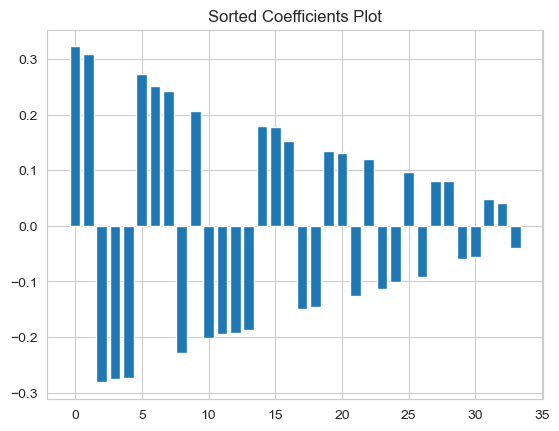

In [41]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ridge_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

The most important features of this model are printed below.

The Mean Absolute Error is worse compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.3531335147440776

The most important features are:

Feature 0 : Literacy_15_24yrs 	Coefficient: -0.15757311859395556
Feature 1 : Minority_rule 	Coefficient: 0.133589348561447
Feature 2 : GDPpc 	Coefficient: -0.10863653602421218
Feature 3 : Internet_use 	Coefficient: -0.08403238950977227
Feature 4 : Armedcon 	Coefficient: 0.009733498053769959
Feature 5 : Democ 	Coefficient: -0.0
Feature 6 : Freemv_M 	Coefficient: -0.0
Feature 7 : Freemv_F 	Coefficient: -0.0
Feature 8 : Free_discuss 	Coefficient: -0.0
Feature 9 : Soc_powerdist 	Coefficient: 0.0
Feature 10 : Sexwrk_condom 	Coefficient: -0.0
Feature 11 : Climate_chg_vuln 	Coefficient: 0.0
Feature 12 : Sexwrk_Syphilis 	Coefficient: 0.0
Feature 13 : AIDS_Orph 	Coefficient: 0.0
Feature 14 : Rape_report 	Coefficient: 0.0
Feature 15 : Rape_enclave 	Coefficient: -0.0
Feature 16 : Phys_secF 	Coefficient: 0.0
Feature 17 : CPI 	Coefficient: -0.0
Feature 18 : KOF_Globalis 	Coefficient: -0.0

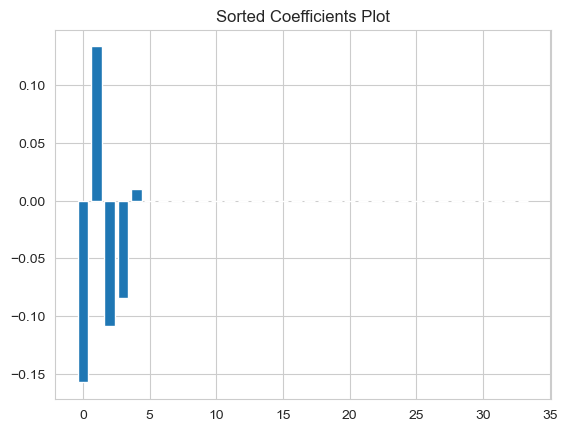

In [42]:
reg = linear_model.Lasso(alpha=0.113) # all coefficients zero = 0.4310284237726099
reg = linear_model.Lasso(alpha=0.067)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_lasso_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [43]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2018)


Mean Absolute Error evaluation on Out of Sample Data is: 0.3470639534883721


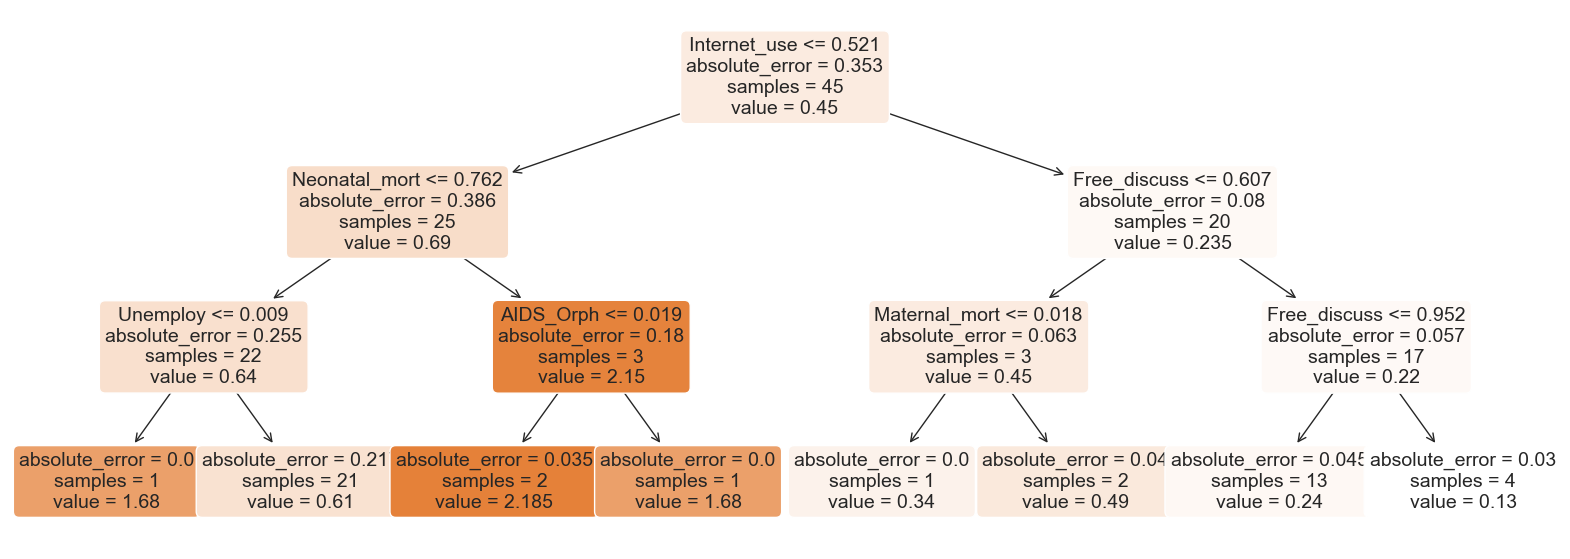

In [44]:
clf = DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=10)
clf = clf.fit(X, y)
y_pred = clf.predict(X_test)
MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_tree_2018)
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(clf, 
                   feature_names=training_2018.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error of the Random Forest is better than the Decision Tree's respective one, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [45]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2018)


Mean Absolute Error evaluation on Out of Sample Data is: 0.3261840116279069

The most important features are:
(The features that have 0 value were not used)

1. feature 17 Internet_use (0.172334)
2. feature 10 Neonatal_mort (0.155935)
3. feature 3 GDPpc (0.087720)
4. feature 24 Free_discuss (0.085862)
5. feature 12 F_school (0.048302)
6. feature 20 CPI (0.037313)
7. feature 4 Armedcon (0.033800)
8. feature 11 Literacy_15_24yrs (0.031043)
9. feature 9 Maternal_mort (0.030200)
10. feature 13 ATMs (0.029601)
11. feature 18 Broadband (0.028053)
12. feature 0 KOF_Globalis (0.026493)
13. feature 6 Stunting_u5s (0.024355)
14. feature 28 Sexwrk_Syphilis (0.023274)
15. feature 16 Infrastruct (0.023148)
16. feature 15 Unemploy (0.022621)
17. feature 29 AIDS_Orph (0.019814)
18. feature 8 Wasting_u5s (0.018976)
19. feature 27 Sexwrk_condom (0.014081)
20. feature 2 Trade_open (0.013553)
21. feature 33 Gender_equal (0.013452)
22. feature 19 Climate_chg_vuln (0.012749)
23. feature 5 Poverty (0.01233

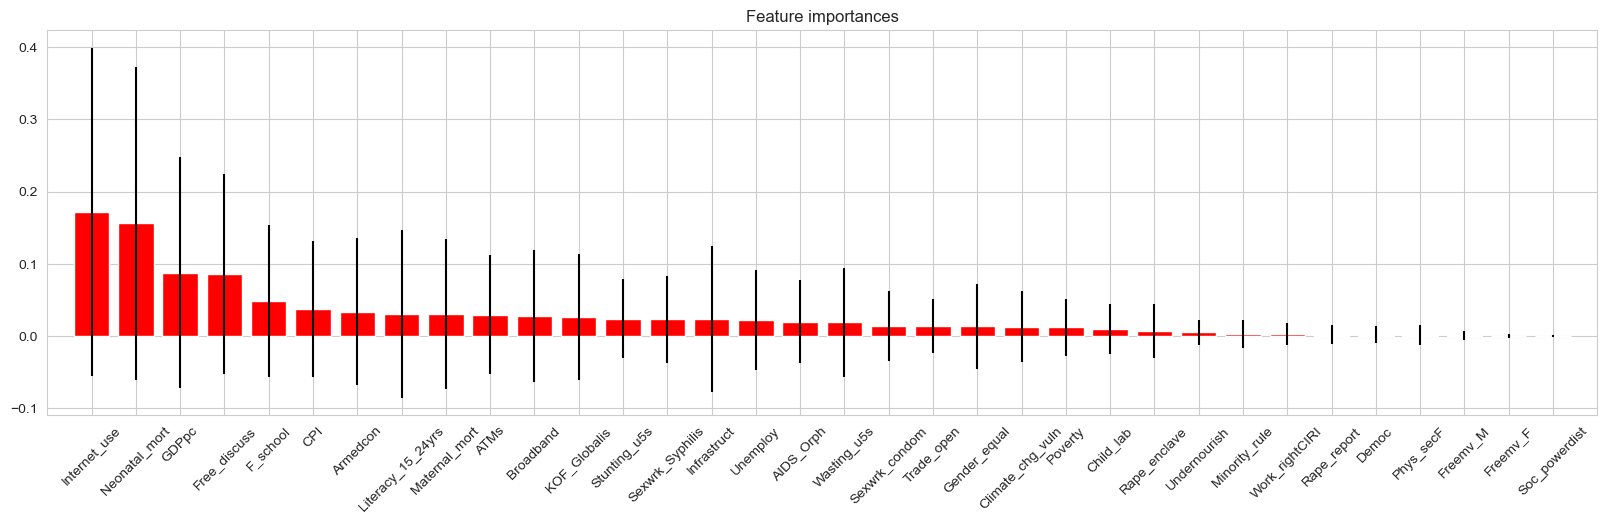

In [46]:
regr = RandomForestRegressor(criterion='absolute_error', max_depth=3, random_state=8)
regr = regr.fit(X, y)
# scores = cross_val_score(regr, X, y, cv=5)
# print(scores.mean())
y_pred = regr.predict(X_test)
MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_forest_2018)
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print('\nThe most important features are:\n(The features that have 0 value were not used)\n')
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(20, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

In [47]:
print_theory1 = 'Final Comparison between 2016 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2016) + '\nRidge:\t' + str(MAE_ridge_2016) + '\nLasso:\t' + str(MAE_lasso_2016) + '\nTree:\t' + str(MAE_tree_2016) + '\nForest:\t' + str(MAE_forest_2016)
print_theory2 = '\n\nFinal Comparison between 2018 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2018) + '\nRidge:\t' + str(MAE_ridge_2018) + '\nLasso:\t' + str(MAE_lasso_2018) + '\nTree:\t' + str(MAE_tree_2018) + '\nForest:\t' + str(MAE_forest_2018)
print_theory = print_theory1 + print_theory2
print(print_theory)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	1.0564987387528428
Ridge:	0.24919838587440732
Lasso:	0.26462964376069115
Tree:	0.31585369400814434
Forest:	0.2915819750372701

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.6683754708308083
Ridge:	0.5422500794419286
Lasso:	0.3531335147440776
Tree:	0.3470639534883721
Forest:	0.3261840116279069


### Q4: Slavery Estimation with PCA-derived Features

At last, the forementioned models were trained on the dataset using Principal Component Analysis (PCA) features in order to reduce the full set of features to six features. 
PCA was fit on the training dataset and transformed both training and test datasets.

In [48]:
y = training.SLAVERY
X = training.loc[:, training.columns != 'SLAVERY']
pca = PCA(n_components=6)
pca.fit(X)
X = pca.transform(X)

training_PCA = pd.DataFrame(X, columns=['PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6',], index=training.index)
training_PCA['SLAVERY'] = y
training_PCA

y = OOS_Data.SLAVERY
X = OOS_Data.loc[:, OOS_Data.columns != 'SLAVERY']
X = pca.transform(X)
OOS_PCA = pd.DataFrame(X, columns=['PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6',], index=OOS_Data.index)
OOS_PCA['SLAVERY'] = y
OOS_PCA

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,SLAVERY
Afghanistan_2016,2.727672,0.068894,0.114458,0.491667,0.209009,0.145970,1.13
Albania_2016,-1.208773,0.451205,0.310265,0.056967,0.185409,0.171444,0.29
Albania_2018,-1.283544,0.419782,0.279700,0.058209,0.224646,0.236103,0.69
Algeria_2016,-0.033183,-0.650163,0.367907,0.041369,0.024806,0.410602,0.63
Algeria_2018,-0.175688,-0.718399,0.334760,-0.103252,0.025793,0.549987,0.27
...,...,...,...,...,...,...,...
Samoa_2018,-0.429555,0.171100,0.909050,-0.326229,-0.091749,-0.230587,1.09
Yemen_2016,2.429517,-1.137066,0.336861,0.968575,-0.222936,-0.451889,1.13
Yemen_2018,2.424725,-1.144093,0.283707,1.017327,-0.304513,-0.411371,0.31
Zambia_2016,0.407275,1.622933,0.331912,-0.355550,-0.710600,0.061712,0.67


#### Interpretation of the six derived PCA features
##### Component 1 : Lack of Freedom, Armed Conflict and Access to Resources
Lack of freedom of movement for women, lack of independence of the Judiciary, political power distributed to the higher social groups, presence of armed conflict or any ongoing mass killing and
lack of access to non-solid fuels, lack of gross development product per capita, lack of improved piped water source and lack of internet use

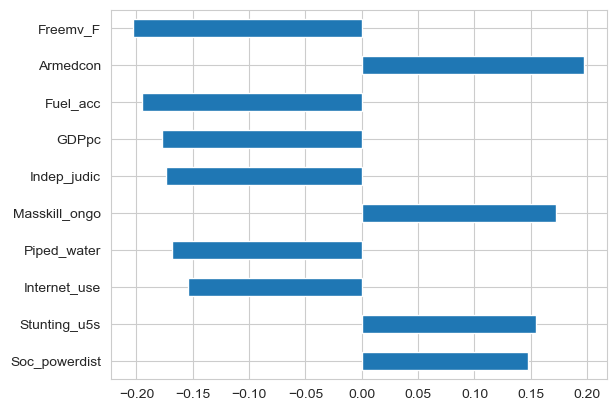

In [49]:
df = pd. DataFrame(pca.components_, columns=training.columns[:-1])
df.index = ['PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6']
PCA_1 = df.loc['PCA_1',:]
PCA_2 = df.loc['PCA_2',:]
PCA_3 = df.loc['PCA_3',:]
PCA_4 = df.loc['PCA_4',:]
PCA_5 = df.loc['PCA_5',:]
PCA_6 = df.loc['PCA_6',:]
PCA_1 = PCA_1.sort_values(key=lambda x: abs(x), ascending=False)[:10]
PCA_2 = PCA_2.sort_values(key=lambda x: abs(x), ascending=False)[:10]
PCA_3 = PCA_3.sort_values(key=lambda x: abs(x), ascending=False)[:10]
PCA_4 = PCA_4.sort_values(key=lambda x: abs(x), ascending=False)[:10]
PCA_5 = PCA_5.sort_values(key=lambda x: abs(x), ascending=False)[:10]
PCA_6 = PCA_6.sort_values(key=lambda x: abs(x), ascending=False)[:10]
ax = PCA_1.iloc[::-1].plot.barh()

##### Component 2 : Religious and Political Freedoms
High loading variables include Freedom of Religion, Freedom of Assembly and Association, Freedom of Domestic Movement, existence of Democracy polity type.

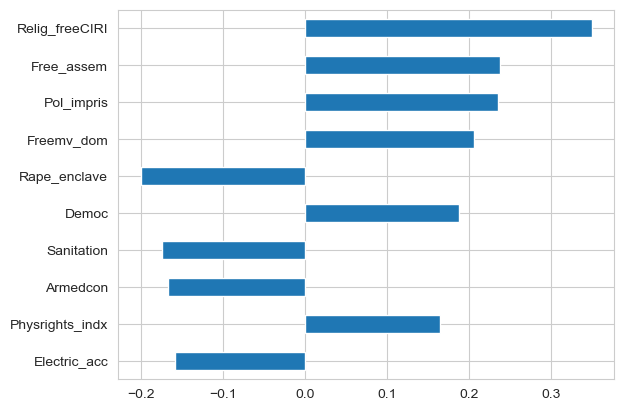

In [50]:
ax = PCA_2.iloc[::-1].plot.barh()

##### Component 3 : Lack of Democracy without existence of War / Violence
The top loading variable is Lack of Democracy. Other high loading variables are the lack of rape enclaves, lack of any mass killing present or past, lack of armed conflict, level of extrajudicial killing by government officials without due process of law, lack of liberal democracy and level of Minority control.

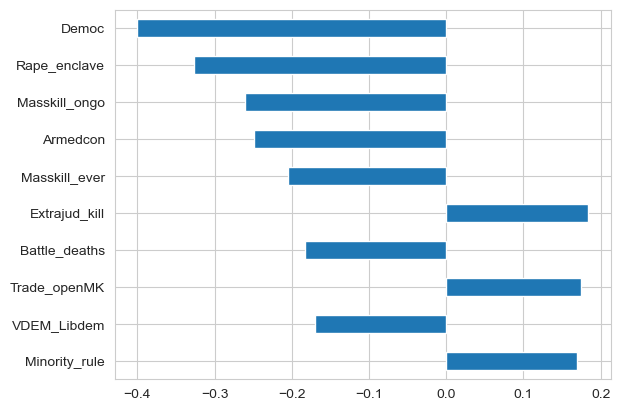

In [51]:
ax = PCA_3.iloc[::-1].plot.barh()

##### Component 4 : Social Inequality
The top loading variable is the level of Minority Control. Other similar high load variable is the lack of independence of the judiciary from other sources's control.

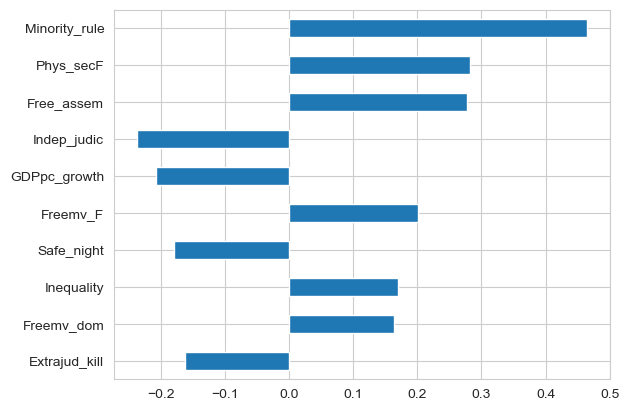

In [52]:
ax = PCA_4.iloc[::-1].plot.barh()

##### Component 5 : Discrimination
The two highest loading variables depicts whether there has ever been a mass killing, such as a genocide, before and the unequal distribution of power between social groups, Restrictions on candidates, minority rule and Political Imprisonment.

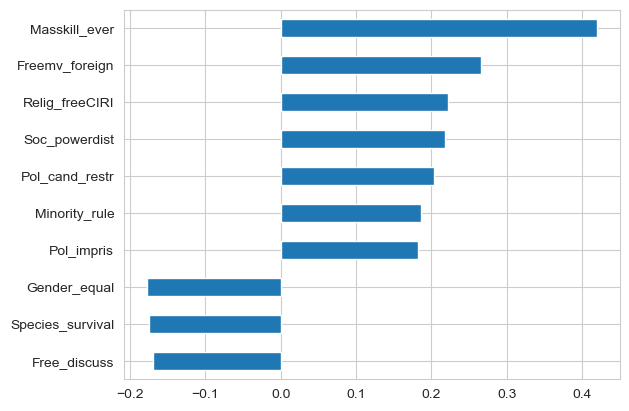

In [53]:
ax = PCA_5.iloc[::-1].plot.barh()

##### Component 6 : Armed Conflict and Lack of Freedom
Lack of Freedom of Domestic Movement, mass killing in the past, existence of armed conflict

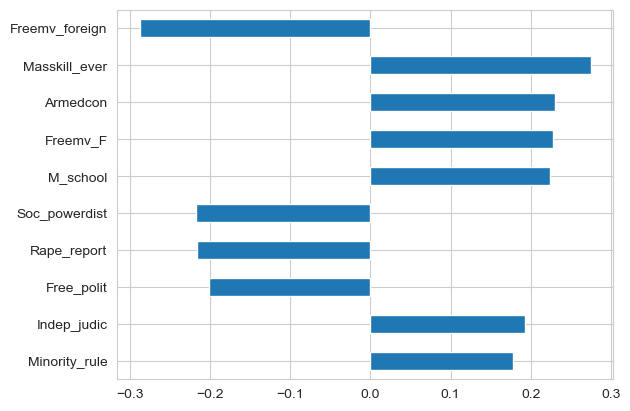

In [54]:
ax = PCA_6.iloc[::-1].plot.barh()

#### Proportion of Variance Explained (PVE) by each Principal Component

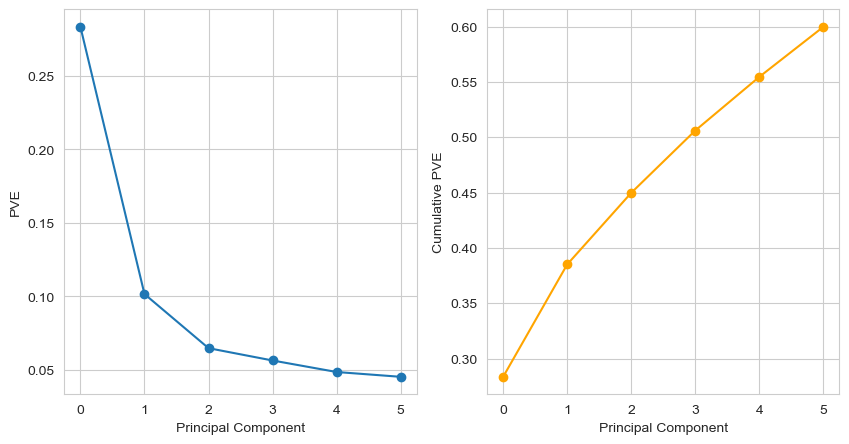

In [55]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('PVE')
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange')
plt.xlabel('Principal Component')
_ = plt.ylabel('Cumulative PVE')

Then, both training and test data were splitted across the forementioned time periods (2016 and 2018).

In [56]:
training_2016 = training_PCA.filter(regex='_2016', axis=0)
training_2018 = training_PCA.filter(regex='_2018', axis=0)
OOS_2016 = OOS_PCA.filter(regex='_2016', axis=0)
OOS_2018 = OOS_PCA.filter(regex='_2018', axis=0)

#### 2016 models

In [57]:
y_test = OOS_2016['SLAVERY']
X_test = OOS_2016.loc[:, OOS_2016.columns != 'SLAVERY']
y = training_2016.SLAVERY
X = training_2016.loc[:, training_2016.columns != 'SLAVERY']

Multicollinearity (VIF) is low, so we trust the coefficients and metrics from the summary statistics.

Important (statistically significant) features of the OLS model is the Intercept and the first Principal Component (PCA_1), because they have a p-value below 0.05.

The following was produced using OLS function of the `Statsmodels` library.

In [58]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
print("Multicollinearity measures:\n")
print(vif_data)
independent_variables = ' + '.join(training_PCA.columns[:-1])
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2016)
ols_full_res = ols_full.fit()
print(ols_full_res.summary())
y_pred = ols_full_res.predict(X_test)
MAE_ols_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_ols_2016)
# get importance
# importance = ols_full_res.params
# importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# # summarize feature importance
# for i in range(len(importance)):
#     print('Feature',i,':',importance.index[i],'Score:',importance[i])
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

Multicollinearity measures:

  feature       VIF
0   PCA_1  1.128611
1   PCA_2  1.081212
2   PCA_3  1.002863
3   PCA_4  1.083588
4   PCA_5  1.029163
5   PCA_6  1.019762
                            OLS Regression Results                            
Dep. Variable:                SLAVERY   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     2.417
Date:                Mon, 27 Feb 2023   Prob (F-statistic):             0.0684
Time:                        23:39:36   Log-Likelihood:                -5.1351
No. Observations:                  25   AIC:                             24.27
Df Residuals:                      18   BIC:                             32.80
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

I also applied Ridge Regression with Cross-Validation. 

The Mean Absolute Error is better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.25402674534364

The most important features are:

Feature 0 : PCA_1 	Coefficient: 0.11729144294246549
Feature 1 : PCA_6 	Coefficient: -0.08527236812294753
Feature 2 : PCA_5 	Coefficient: 0.07213812563831216
Feature 3 : PCA_3 	Coefficient: 0.05840297176032205
Feature 4 : PCA_4 	Coefficient: 0.0561494592721461
Feature 5 : PCA_2 	Coefficient: -0.007960072297586523


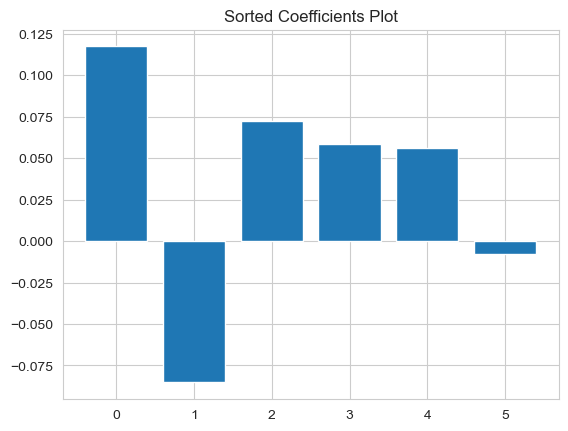

In [59]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_ridge_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

The most important features of this model are printed below.

The Mean Absolute Error is slightly better compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.25323673221736254

The most important features are:

Feature 0 : PCA_1 	Coefficient: 0.12463399400859304
Feature 1 : PCA_6 	Coefficient: -0.09272981673477085
Feature 2 : PCA_5 	Coefficient: 0.06887150528209716
Feature 3 : PCA_3 	Coefficient: 0.04845294377723252
Feature 4 : PCA_4 	Coefficient: 0.04297517070819537
Feature 5 : PCA_2 	Coefficient: -0.0


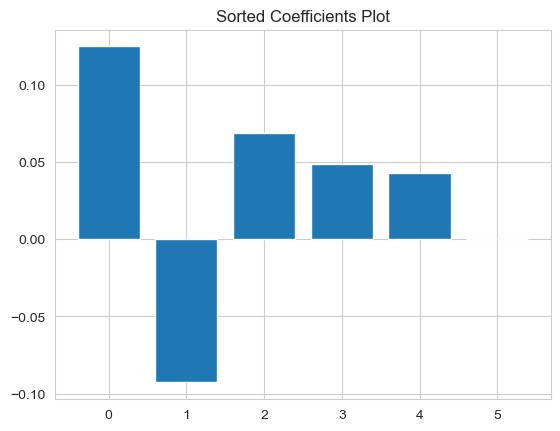

In [60]:
reg = linear_model.Lasso(alpha=0.069) # all coefficients zero
reg = linear_model.Lasso(alpha=0.030)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_lasso_2016)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [61]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.2920792819745699


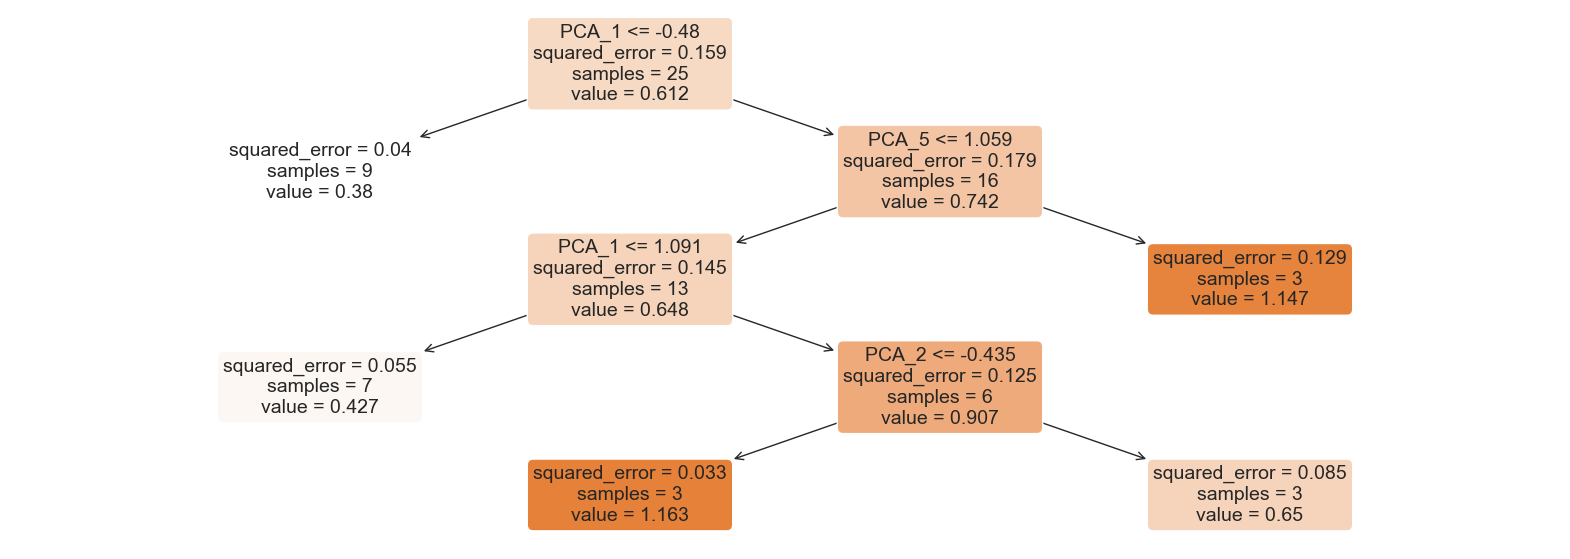

In [62]:
tree_regr = DecisionTreeRegressor(ccp_alpha=0.01, max_depth=4, max_features='sqrt', splitter='random', random_state=2)
# DecisionTreeRegressor(ccp_alpha=0.01, max_depth=2, max_features='log2', splitter='random', random_state=1)
tree_regr.fit(X, y)
# print(tree_regr)
y_pred = tree_regr.predict(X_test)
MAE_tree_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_tree_2016)
# print(tree_regr.get_depth())
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(tree_regr, 
                   feature_names=training_2016.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error of the Random Forest is better than the Decision Tree's respective one, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [63]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2016)


Mean Absolute Error evaluation on Out of Sample Data is: 0.28864990327572937

The most important features are:
(The features that have 0 value were not used)

1. feature 0 PCA_1 (0.309904)
2. feature 4 PCA_5 (0.165031)
3. feature 5 PCA_6 (0.149364)
4. feature 1 PCA_2 (0.139306)
5. feature 2 PCA_3 (0.138636)
6. feature 3 PCA_4 (0.097760)


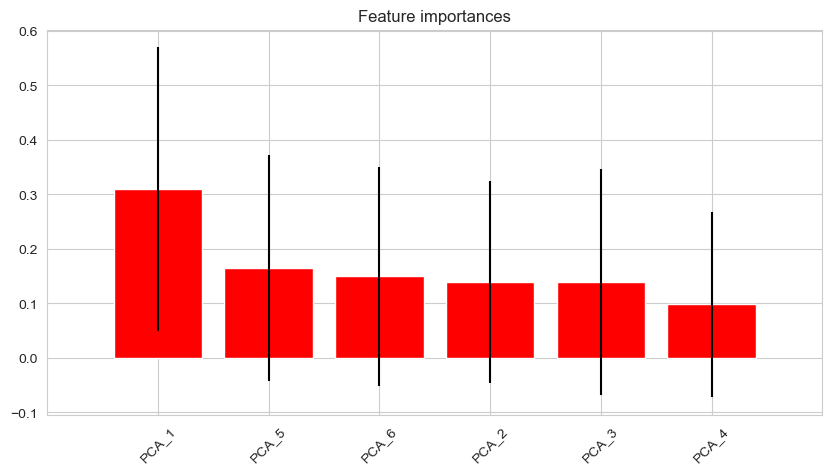

In [64]:
regr = RandomForestRegressor(ccp_alpha=0.01, max_depth=4, max_features='log2', random_state=8)
regr.fit(X, y)
# print(regr)
y_pred = regr.predict(X_test)
MAE_forest_2016 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_forest_2016)
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print('\nThe most important features are:\n(The features that have 0 value were not used)\n')
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

#### 2018 models

For the 2018 dataset, I splitted the features (for both train and test data) on the dependent variable (Slavery Prevalence) and independent variables.

In [65]:
y_test = OOS_2018['SLAVERY']
X_test = OOS_2018.loc[:, OOS_2018.columns != 'SLAVERY']
y = training_2018.SLAVERY
X = training_2018.loc[:, training_2018.columns != 'SLAVERY']

Multicollinearity (VIF) is low, so we trust the coefficients and metrics from the summary statistics.

Important (statistically significant) features of the OLS model is the Intercept, the first and third Principal Component (PCA_1, PCA_3), because they have a p-value below 0.05.

The following was produced using OLS function of the `Statsmodels` library.

In [66]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
print("Multicollinearity measures:\n")
print(vif_data)
ols_full = smf.ols("SLAVERY ~ " + independent_variables, data=training_2018)
ols_full_res = ols_full.fit()
print(ols_full_res.summary())
y_pred = ols_full_res.predict(X_test)
MAE_ols_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:',MAE_ols_2018)
# # get importance
# importance = ols_full_res.params
# importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# # summarize feature importance
# for i in range(len(importance)):
#     print('Feature',i,':',importance.index[i],'Score:',importance[i])
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

Multicollinearity measures:

  feature       VIF
0   PCA_1  1.040701
1   PCA_2  1.028383
2   PCA_3  1.001535
3   PCA_4  1.030356
4   PCA_5  1.010780
5   PCA_6  1.007930
                            OLS Regression Results                            
Dep. Variable:                SLAVERY   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     7.350
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           2.90e-05
Time:                        23:39:37   Log-Likelihood:                -16.533
No. Observations:                  45   AIC:                             47.07
Df Residuals:                      38   BIC:                             59.71
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

I also applied Ridge Regression with Cross-Validation. 

The Mean Absolute Error is better compared to the OLS model.

The most important features of this model are printed below.


Mean Absolute Error evaluation on Out of Sample Data is: 0.3915790232203021

The most important features are:

Feature 0 : PCA_1 	Coefficient: 0.2006459817454649
Feature 1 : PCA_3 	Coefficient: 0.1359229766975345
Feature 2 : PCA_4 	Coefficient: 0.045268959073537555
Feature 3 : PCA_2 	Coefficient: 0.04170953892846899
Feature 4 : PCA_5 	Coefficient: 0.040122724067874614
Feature 5 : PCA_6 	Coefficient: 0.023362605368465565


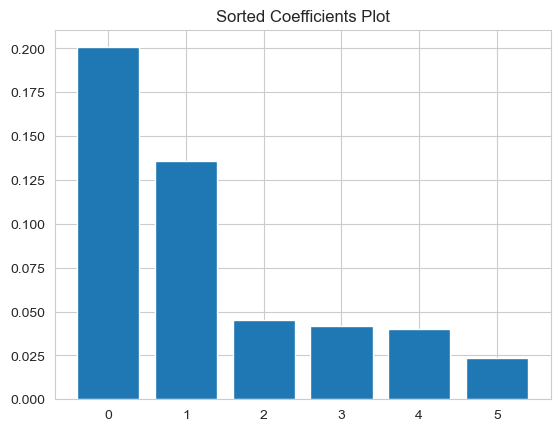

In [67]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg = reg.fit(X, y)
# print(reg.alpha_)
y_pred = reg.predict(X_test)
MAE_ridge_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_ridge_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

I also applied Lasso Regression. 

The most important features of this model are printed below.

The Mean Absolute Error is slightly better compared to the Ridge Regression model.


Mean Absolute Error evaluation on Out of Sample Data is: 0.3389711917349099

The most important features are:

Feature 0 : PCA_1 	Coefficient: 0.09592251431070922
Feature 1 : PCA_2 	Coefficient: 0.0
Feature 2 : PCA_3 	Coefficient: 0.0
Feature 3 : PCA_4 	Coefficient: 0.0
Feature 4 : PCA_5 	Coefficient: 0.0
Feature 5 : PCA_6 	Coefficient: 0.0


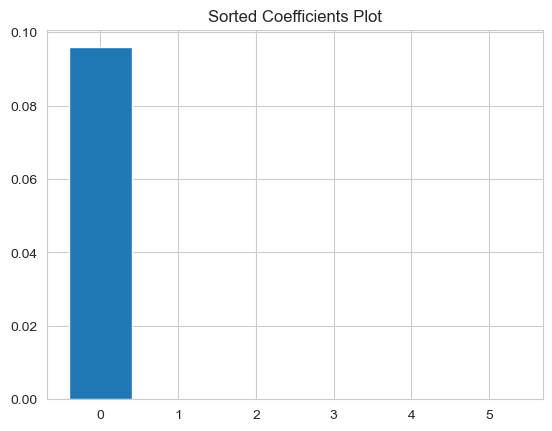

In [68]:
reg = linear_model.Lasso(alpha=0.52) # all coefficients zero = 0.4310284237726099
reg = linear_model.Lasso(alpha=0.30)
reg = reg.fit(X, y)
y_pred = reg.predict(X_test)
MAE_lasso_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_lasso_2018)
# get importance
importance = pd.Series(reg.coef_)
importance.index = ols_full_res.params.index[1:]
importance = importance.sort_values(key=lambda x: abs(x), ascending=False)
# summarize feature importance
print('\nThe most important features are:\n')
for i in range(len(importance)):
    print('Feature',i,':',importance.index[i],'\tCoefficient:',importance[i])
# plot feature importance
plt.title('Sorted Coefficients Plot')
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

##### Decision Tree

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `DecisionTreeRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error is worse than Ridge and Lasso Regression. 
The important features on predicting slavery prevalence implied by the model are those mentioned as conditions at the root and intermediate nodes (not the leafs) of the plotted tree.

In [69]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'splitter': ['best', 'random'],
# #               'random_state': range(10)
#              }
# # scoring='neg_mean_absolute_error',
# tree_regr = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# tree_regr = grid_search.best_estimator_
# tree_regr.fit(X, y)
# print(tree_regr)
# y_pred = grid_search.predict(X_test)
# MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_tree_2018)


Mean Absolute Error evaluation on Out of Sample Data is: 0.31281976744186046


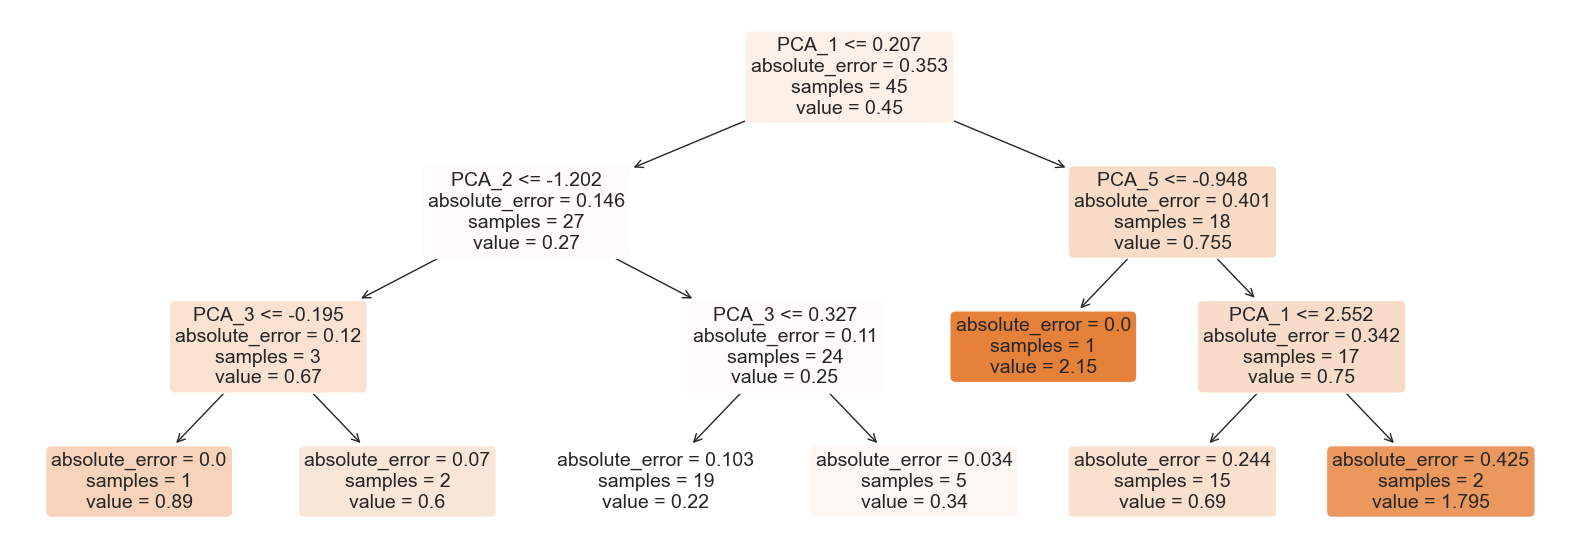

In [70]:
clf = DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=4)
clf = clf.fit(X, y)
y_pred = clf.predict(X_test)
MAE_tree_2018 = mean_absolute_error(y_test, y_pred)
print('\nMean Absolute Error evaluation on Out of Sample Data is:', MAE_tree_2018)
plt.figure(figsize=(20, 7))
_ = tree.plot_tree(clf, 
                   feature_names=training_2018.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

##### Random Forest

I have used a Grid Search Cross-Validation in order to find with exhaustive search over specified parameter values the best possible hypermarameters of `RandomForestRegressor` of `scikit-learn`'s library. Then, I controled the randomness of the estimator in order to obtain a deterministic behaviour during fitting.

The Mean Absolute Error of the Random Forest is better than the Decision Tree's respective one, as expected. Below it is dynamically being shown the feature importance of the trained model.

In [71]:
# param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'ccp_alpha': [0.1, .01, .001],
#               'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
#               'criterion': ['squared_error', 'absolute_error'],
#               'n_estimators': [50, 100, 150, 200],
#              }
# # scoring = {"MAE": "neg_mean_absolute_error", "squared_error": "neg_mean_squared_error"}
# forest_regr = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=forest_regr, param_grid=param_grid, cv=5, verbose=True)
# grid_search.fit(X, y)
# regr = grid_search.best_estimator_
# # regr = RandomForestRegressor(ccp_alpha=0.1, max_depth=2, n_estimators=50)
# regr.fit(X, y)
# print(regr)
# y_pred = regr.predict(X_test)
# MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
# print(MAE_forest_2018)

0.31032325581395354
1. feature 0 PCA_1 (0.595416)
2. feature 2 PCA_3 (0.135839)
3. feature 4 PCA_5 (0.085059)
4. feature 1 PCA_2 (0.077083)
5. feature 3 PCA_4 (0.064375)
6. feature 5 PCA_6 (0.042228)


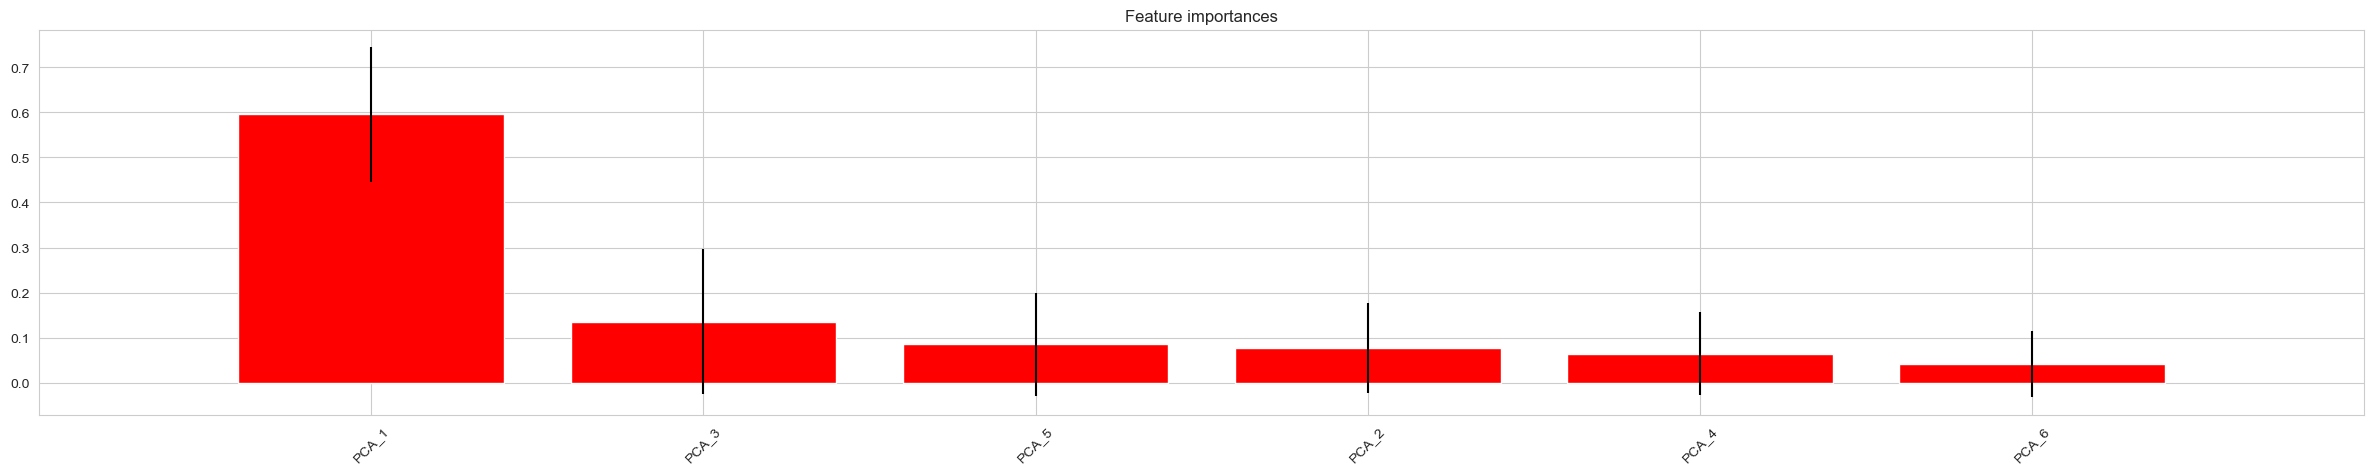

In [72]:
regr = RandomForestRegressor(criterion='absolute_error', max_depth=3, random_state=1)
regr = regr.fit(X, y)
# scores = cross_val_score(regr, X, y, cv=5)
# print(scores.mean())
y_pred = regr.predict(X_test)
MAE_forest_2018 = mean_absolute_error(y_test, y_pred)
print(MAE_forest_2018)
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure(figsize=(30, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[X.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

In [73]:
print_PCA1 = 'Final Comparison between 2016 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2016) + '\nRidge:\t' + str(MAE_ridge_2016) + '\nLasso:\t' + str(MAE_lasso_2016) + '\nTree:\t' + str(MAE_tree_2016) + '\nForest:\t' + str(MAE_forest_2016)
print_PCA2 = '\n\nFinal Comparison between 2018 models (Mean Absolute Error):\n' + 'OLS:\t' + str(MAE_ols_2018) + '\nRidge:\t' + str(MAE_ridge_2018) + '\nLasso:\t' + str(MAE_lasso_2018) + '\nTree:\t' + str(MAE_tree_2018) + '\nForest:\t' + str(MAE_forest_2018)
print_PCA = print_PCA1 + print_PCA2
print(print_PCA)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	0.3112413528230387
Ridge:	0.25402674534364
Lasso:	0.25323673221736254
Tree:	0.2920792819745699
Forest:	0.28864990327572937

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.40872464075249393
Ridge:	0.3915790232203021
Lasso:	0.3389711917349099
Tree:	0.31281976744186046
Forest:	0.31032325581395354


### Final Comparison between all models

#### All Features

In [74]:
print(print_full)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	0.536760920644268
Ridge:	0.3031765289880392
Lasso:	0.25006862425104043
Tree:	0.31870855148342053
Forest:	0.28671619384879743

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.5320045467380722
Ridge:	0.38464597853168025
Lasso:	0.328918318536278
Tree:	0.3547093023255814
Forest:	0.33941453488372103


#### Theory Features

In [75]:
print(print_theory)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	1.0564987387528428
Ridge:	0.24919838587440732
Lasso:	0.26462964376069115
Tree:	0.31585369400814434
Forest:	0.2915819750372701

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.6683754708308083
Ridge:	0.5422500794419286
Lasso:	0.3531335147440776
Tree:	0.3470639534883721
Forest:	0.3261840116279069


#### PCA Features

In [76]:
print(print_PCA)

Final Comparison between 2016 models (Mean Absolute Error):
OLS:	0.3112413528230387
Ridge:	0.25402674534364
Lasso:	0.25323673221736254
Tree:	0.2920792819745699
Forest:	0.28864990327572937

Final Comparison between 2018 models (Mean Absolute Error):
OLS:	0.40872464075249393
Ridge:	0.3915790232203021
Lasso:	0.3389711917349099
Tree:	0.31281976744186046
Forest:	0.31032325581395354
